# COMP30760 Data Science in Python: Assignment 2 : SN 20368431 

In [1]:
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline

First assign the link provided changing Student Number to 20368431 which is my student number.

In [2]:
link = "http://mlg.ucd.ie/modules/COMP30760/assign2/20368431.html"
#using urrlib.request.uropen to open the link provided
response = urllib.request.urlopen(link)
#then assign the decoded data to the variable html
html = response.read().decode()

The using the pandas library to read the html and make it into a table

In [3]:
data = pd.read_html(html)

In [4]:
#print said table
data

[    Date of Sale        Price    Location  Year Built         Size  \
 0    03 Jan 2016  €638,740.00  Brookville        2011  1,849 sq ft   
 1    03 Jan 2016  €494,549.00  Brookville        2009  1,471 sq ft   
 2    07 Jan 2016  €546,330.00  Brookville        2009  1,551 sq ft   
 3    10 Jan 2016  €376,039.00    West End        1963  1,073 sq ft   
 4    10 Jan 2016  €365,696.00    West End        1959  1,071 sq ft   
 ..           ...          ...         ...         ...          ...   
 923  27 Dec 2019  €228,647.00   Rivermont        1946    887 sq ft   
 924  27 Dec 2019  €312,722.00   Rivermont        1881  2,323 sq ft   
 925  28 Dec 2019  €410,983.00    Oakbrook        1968  1,453 sq ft   
 926  29 Dec 2019  €531,880.00    West End        2010  2,283 sq ft   
 927  29 Dec 2019  €347,582.00    West End        1964    832 sq ft   
 
                                            Description  
 0    Type: Detached; Style: 2-Story; 3 Bedrooms; 2 ...  
 1    Type: Detached; Style: 1

In [5]:
#the table includes two parts but all the data is in one column do assign data[0] to a dataframe
house_df = data[0]

In [6]:
house_df

,Date of Sale,Price,Location,Year Built,Size,Description
0,03 Jan 2016,"€638,740.00",Brookville,2011,"1,849 sq ft",Type: Detached; Style: 2-Story; 3 Bedrooms; 2 ...
1,03 Jan 2016,"€494,549.00",Brookville,2009,"1,471 sq ft",Type: Detached; Style: 1-Story; 3 Bedrooms; 2 ...
2,07 Jan 2016,"€546,330.00",Brookville,2009,"1,551 sq ft",Type: Detached; Style: 1-Story; 3 Bedrooms; 2 ...
3,10 Jan 2016,"€376,039.00",West End,1963,"1,073 sq ft",Type: Terraced; Style: 1-Story; 3 Bedrooms; 1 ...
4,10 Jan 2016,"€365,696.00",West End,1959,"1,071 sq ft",Type: Terraced; Style: 1-Story; 3 Bedrooms; 1 ...
...,...,...,...,...,...,...
923,27 Dec 2019,"€228,647.00",Rivermont,1946,887 sq ft,Type: Bunaglow; Style: 1-Story; 2 Bedrooms; 1 ...
924,27 Dec 2019,"€312,722.00",Rivermont,1881,"2,323 sq ft",Type: Detached; Style: 2-Story; 5 Bedrooms; 2 ...
925,28 Dec 2019,"€410,983.00",Oakbrook,1968,"1,453 sq ft",Type: Detached; Style: 1-Story; 3 Bedrooms; 2 ...
926,29 Dec 2019,"€531,880.00",West End,2010,"2,283 sq ft",Type: Detached; Style: 2-Story; 4 Bedrooms; 2 ...


check if there are any empty values

In [7]:
house_df.isnull().sum()

Date of Sale    0
Price           0
Location        0
Year Built      0
Size            0
Description     0
dtype: int64

change the string format of the date in the orignal to a datetime to be used in the timeseries

In [8]:
house_df["Date of Sale"] =  pd.to_datetime(house_df["Date of Sale"])

In [9]:
#make the date the index
ts = house_df.set_index("Date of Sale")

The description column has multiple different data points that can be used to evaluate the data such as bathrooms, stories, the type of house and the the number of bedrooms.

In [10]:
#split the string in the Description column after the 'Type: ' and take the second column and split that at the first '; ' 
#then make a new column called type and make the string in the first column of new1 the value
#then check that there are no errors by checking the value counts to make sure they sum to 928 which is the number of rows
new = ts["Description"].str.split("Type: ", n = 1,expand = True)
new1 = new[1].str.split("; ", expand = True)
ts["Type"] = new1[0]
ts["Type"].value_counts()

Detached          713
Bunaglow           81
Semi-Detached      55
End-of-Terrace     29
Duplex             26
Terraced           24
Name: Type, dtype: int64

In [11]:
# Do the same as previous put after style to get the number of stories, store this in Stories column
new = ts["Description"].str.split("Style: ", n = 1,expand = True)
new1 = new[1].str.split("; ", expand = True)
ts["Stories"] = new1[0]
ts["Stories"].value_counts()

1-Story      551
2-Story      320
1.5-Story     57
Name: Stories, dtype: int64

In [12]:
#This still leaves '-Story' at the end of each value so remove it to get only a number
ts['Stories'] = ts['Stories'].replace('-Story', '', regex=True)

In [13]:
#again for the number of bedrooms
new = ts["Description"].str.split("Bedroom", n = 1,expand = True)
l = new[0].str[-2]
ts["Bedrooms"] = l
ts["Bedrooms"].value_counts()

3    559
2    209
4    125
1     22
5     13
Name: Bedrooms, dtype: int64

In [14]:
#again for the nuumber of bathrooms
new = ts["Description"].str.split("Bathroom", n = 1,expand = True)
last_char = new[0].str[-2]
ts["Bathrooms"] = last_char
ts["Bathrooms"].value_counts()

2    501
1    403
3     24
Name: Bathrooms, dtype: int64

In [15]:
#all the cents values are .00 so remove them before converting to an int
ts["Price"] = ts["Price"].str[:-3]
ts

,Price,Location,Year Built,Size,Description,Type,Stories,Bedrooms,Bathrooms
Date of Sale,,,,,,,,,
2016-01-03,"€638,740",Brookville,2011,"1,849 sq ft",Type: Detached; Style: 2-Story; 3 Bedrooms; 2 ...,Detached,2,3,2
2016-01-03,"€494,549",Brookville,2009,"1,471 sq ft",Type: Detached; Style: 1-Story; 3 Bedrooms; 2 ...,Detached,1,3,2
2016-01-07,"€546,330",Brookville,2009,"1,551 sq ft",Type: Detached; Style: 1-Story; 3 Bedrooms; 2 ...,Detached,1,3,2
2016-01-10,"€376,039",West End,1963,"1,073 sq ft",Type: Terraced; Style: 1-Story; 3 Bedrooms; 1 ...,Terraced,1,3,1
2016-01-10,"€365,696",West End,1959,"1,071 sq ft",Type: Terraced; Style: 1-Story; 3 Bedrooms; 1 ...,Terraced,1,3,1
...,...,...,...,...,...,...,...,...,...
2019-12-27,"€228,647",Rivermont,1946,887 sq ft,Type: Bunaglow; Style: 1-Story; 2 Bedrooms; 1 ...,Bunaglow,1,2,1
2019-12-27,"€312,722",Rivermont,1881,"2,323 sq ft",Type: Detached; Style: 2-Story; 5 Bedrooms; 2 ...,Detached,2,5,2
2019-12-28,"€410,983",Oakbrook,1968,"1,453 sq ft",Type: Detached; Style: 1-Story; 3 Bedrooms; 2 ...,Detached,1,3,2


In [16]:
#for price remove all non-numeric values from the string then convert this to an integer
ts["Price"] = ts.Price.replace('\D', '', regex=True).astype(int)

In [17]:
#do the same for the size column
ts["Size"] = ts.Size.replace('\D', '', regex=True).astype(int)

In [18]:
#after splitting up description into its parts i can now drop it from the df
ts = ts.drop('Description', axis=1)

In [19]:
#convert from a string to a numeric value
ts["Stories"] = ts["Stories"].astype(float)
ts["Bathrooms"] = ts["Bathrooms"].astype(float)
ts["Bedrooms"] = ts["Bedrooms"].astype(float)

In [20]:
#print the data frame to make sure it is fine
ts

,Price,Location,Year Built,Size,Type,Stories,Bedrooms,Bathrooms
Date of Sale,,,,,,,,
2016-01-03,638740,Brookville,2011,1849,Detached,2.0,3.0,2.0
2016-01-03,494549,Brookville,2009,1471,Detached,1.0,3.0,2.0
2016-01-07,546330,Brookville,2009,1551,Detached,1.0,3.0,2.0
2016-01-10,376039,West End,1963,1073,Terraced,1.0,3.0,1.0
2016-01-10,365696,West End,1959,1071,Terraced,1.0,3.0,1.0
...,...,...,...,...,...,...,...,...
2019-12-27,228647,Rivermont,1946,887,Bunaglow,1.0,2.0,1.0
2019-12-27,312722,Rivermont,1881,2323,Detached,2.0,5.0,2.0
2019-12-28,410983,Oakbrook,1968,1453,Detached,1.0,3.0,2.0


The numeric data features are Price, Size, Yeat built, Stories, Bedrooms and Bathrooms. The rest are categorical. Price is in euros, and size in in feet. 
1. Price is the price of the house sold in euro.
2. Size is the size of the house in feet.
3. Stories is the number of stories in the house. They are either 1, 1.5 or 2
4. The index is the date that the house was sold on
5. Type is the type of house. For example: Detatched or Bungalow
6. Bedrooms is the number of bedrooms.
7. Bathrooms is the number of bathrooms.
8. Locations is the area the house is in

Next i'm going to create a number of histrograms showing the distribution of the amount of houses sold by each data point. Like Price, Size, Stories, bathrooms and bedrooms.

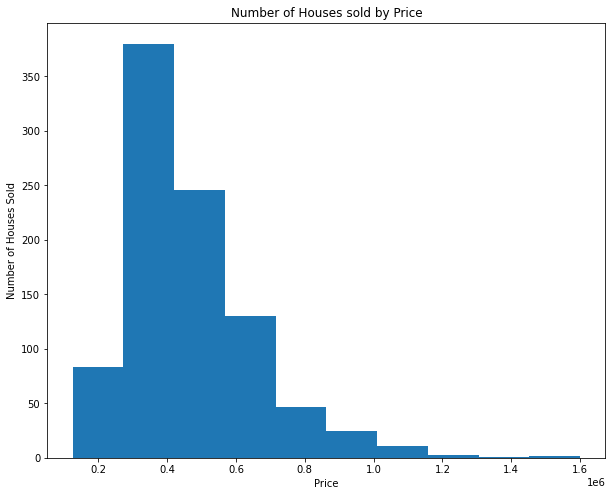

In [21]:
#Create a histogram that shows the number of houses sold by their price
ax = ts["Price"].plot.hist(figsize=(10, 8))
ax.set_xlabel("Price")
ax.set_ylabel("Number of Houses Sold")
ax.set_title("Number of Houses sold by Price")
plt.show()

The majority of houses sold are valued between 0.4m and 0.7m anything either side is an outlier. This suggests that there are not very many houses cheaper and that few people can afford a house above that price.

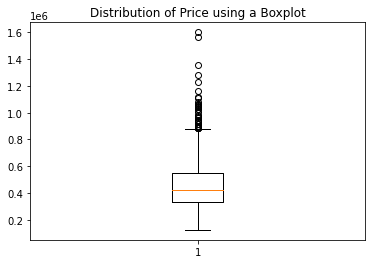

In [22]:
#Next I will create a boxplot for the same data. I will do this for all that follow
ax = plt.boxplot(ts["Price"])
plt.title("Distribution of Price using a Boxplot")
plt.show()

This shows that most homes are between 0.2m and just over 0.8m . There are quite a few outliers above the price of 0.8m. This corroborates the histogram above.

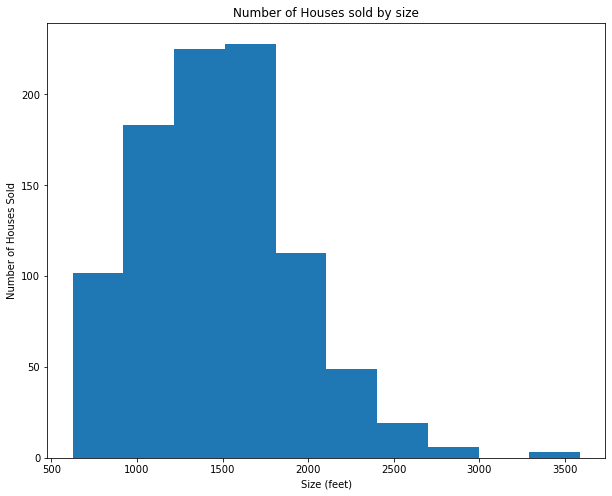

In [23]:
ax = ts["Size"].plot.hist(column=["Size"] ,figsize=(10, 8))
ax.set_xlabel("Size (feet)")
ax.set_ylabel("Number of Houses Sold")
ax.set_title("Number of Houses sold by size")
plt.show()

The overwhelming majority of houses are less than 2000 feet a very insignificant number of houses are above this. The median appears to be around 1500 feet.

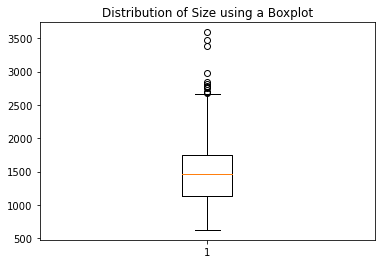

In [24]:
ax = plt.boxplot(ts["Size"])
plt.title("Distribution of Size using a Boxplot")
plt.show()

The distribution of the size of houses sold is between around 500 feet and 2500 feet. The median size is as seen before around 1500 feet.

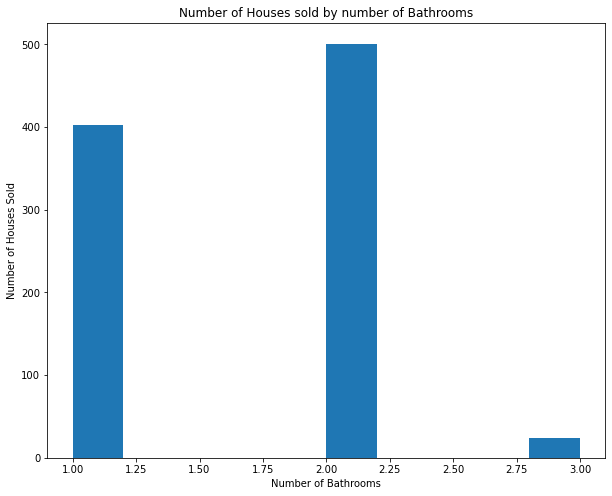

In [25]:
ax = ts["Bathrooms"].plot.hist(column=["Bathrooms"], figsize=(10, 8))
ax.set_xlabel("Number of Bathrooms")
ax.set_ylabel("Number of Houses Sold")
ax.set_title("Number of Houses sold by number of Bathrooms")
plt.show()

Almost all the houses have 1 or two bathrooms. Two is the most common and 3 is rare.

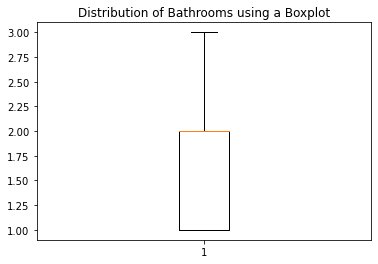

In [26]:
ax = plt.boxplot(ts["Bathrooms"])
plt.title("Distribution of Bathrooms using a Boxplot")
plt.show()

There are no outliers in the data although the box plot makes clear that the average number is 2 and the majority are 1 or 2

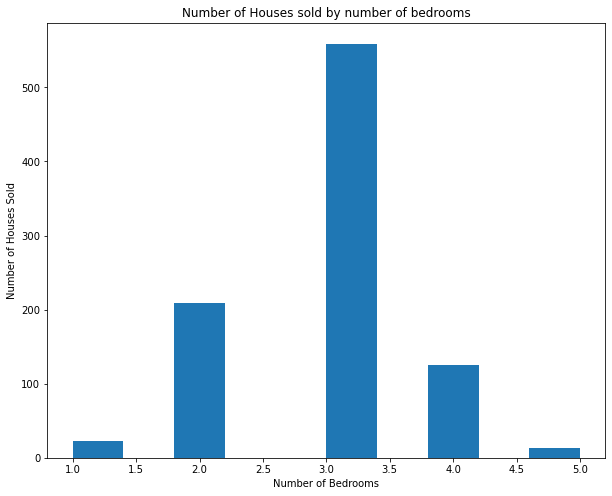

In [27]:
ax = ts["Bedrooms"].plot.hist(column=["Size"], figsize=(10, 8))
ax.set_xlabel("Number of Bedrooms")
ax.set_ylabel("Number of Houses Sold")
ax.set_title("Number of Houses sold by number of bedrooms")
plt.show()

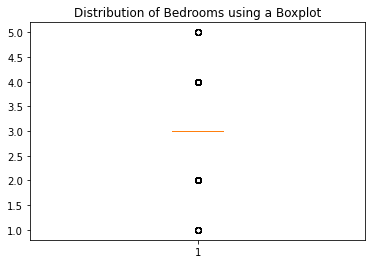

In [28]:
ax = plt.boxplot(ts["Bedrooms"])
plt.title("Distribution of Bedrooms using a Boxplot")
plt.show()

The majority have 3 bedrooms , next is 2 bedrooms but this is significantly less than those that have 3. 1 and 5 are both very rare. All except 3 are outliers.

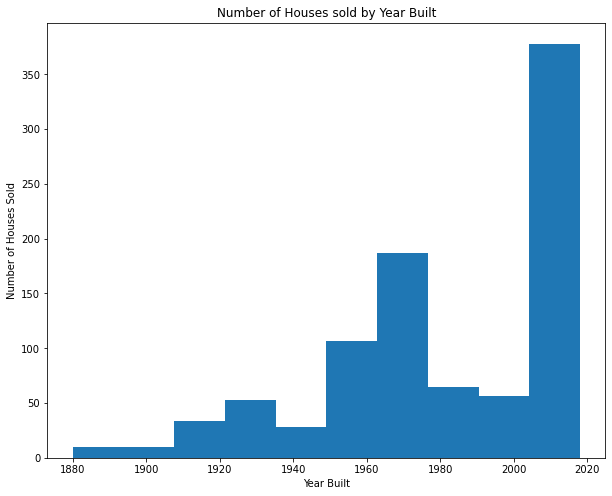

In [29]:
ax = ts["Year Built"].plot.hist(column=["Year Built"], figsize=(10, 8))
ax.set_xlabel("Year Built")
ax.set_ylabel("Number of Houses Sold")
ax.set_title("Number of Houses sold by Year Built")
plt.show()

The number of houses have increased massively since the 2000. This though follows a significant drop from the 70s to the 80s and 90s.

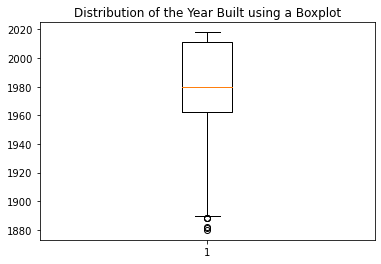

In [30]:
ax = plt.boxplot(ts["Year Built"])
plt.title("Distribution of the Year Built using a Boxplot")
plt.show()

The median year of the houses built was 1980. Though there is a good spread of data from the end of the 1800s. those built before 1890 are outliers in the data. 

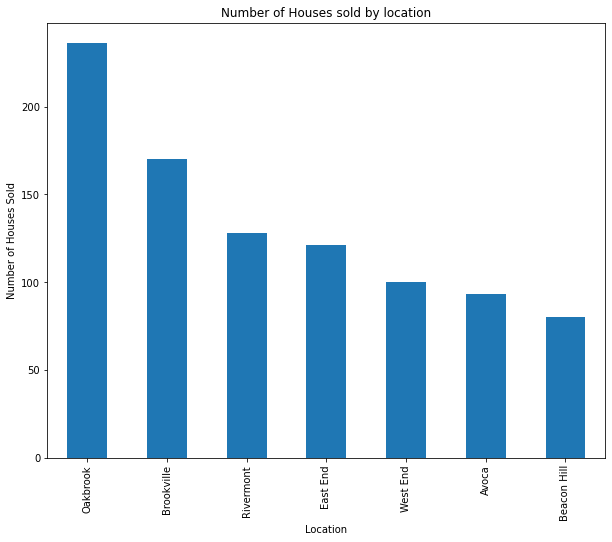

In [31]:
ax = ts["Location"].value_counts().plot(kind = 'bar' ,figsize=(10, 8))
ax.set_xlabel("Location")
ax.set_ylabel("Number of Houses Sold")
ax.set_title("Number of Houses sold by location")
plt.show()

The number of houses sold in Oakbrook are significantly higher than the rest which follow a more linear progression. This could suggest a cheaper area, better access in regards to services or jobs.

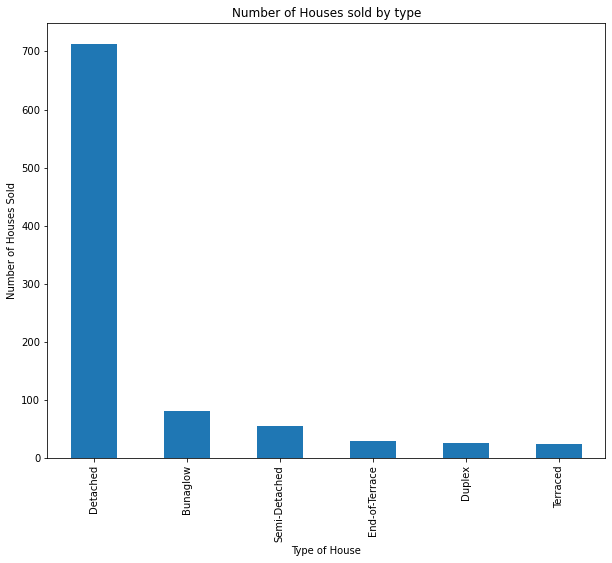

In [32]:
ax = ts["Type"].value_counts().plot(kind = 'bar' ,figsize=(10, 8))
ax.set_xlabel("Type of House")
ax.set_ylabel("Number of Houses Sold")
ax.set_title("Number of Houses sold by type")
plt.show()

Detached housing accounts for around 700 of the houses sold, the next highest being less the 100! This is an overwhelming majority of the houses sold. This points towards the houses being in private areas.

## Time Series Analysis

Next it is time for a time series analysis.

In [33]:
ts
#print the dataframe.

,Price,Location,Year Built,Size,Type,Stories,Bedrooms,Bathrooms
Date of Sale,,,,,,,,
2016-01-03,638740,Brookville,2011,1849,Detached,2.0,3.0,2.0
2016-01-03,494549,Brookville,2009,1471,Detached,1.0,3.0,2.0
2016-01-07,546330,Brookville,2009,1551,Detached,1.0,3.0,2.0
2016-01-10,376039,West End,1963,1073,Terraced,1.0,3.0,1.0
2016-01-10,365696,West End,1959,1071,Terraced,1.0,3.0,1.0
...,...,...,...,...,...,...,...,...
2019-12-27,228647,Rivermont,1946,887,Bunaglow,1.0,2.0,1.0
2019-12-27,312722,Rivermont,1881,2323,Detached,2.0,5.0,2.0
2019-12-28,410983,Oakbrook,1968,1453,Detached,1.0,3.0,2.0


In [34]:
#first create a series of the number of houses sold each day
soldPerDay = pd.Series(ts.index.value_counts())
soldPerDay

2016-03-16    8
2018-06-12    7
2019-05-23    6
2018-05-07    6
2019-03-22    6
             ..
2017-02-20    1
2017-02-11    1
2017-02-06    1
2017-02-04    1
2018-10-31    1
Name: Date of Sale, Length: 500, dtype: int64

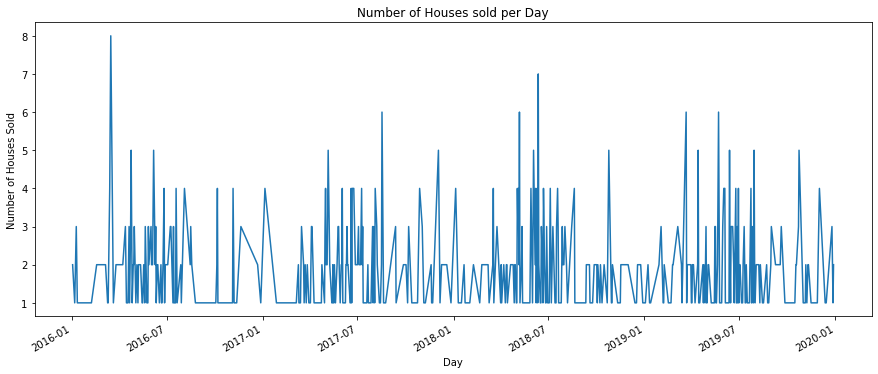

In [35]:
ax = soldPerDay.plot(figsize=(15, 6))
ax.set_xlabel("Day")
ax.set_ylabel("Number of Houses Sold")
ax.set_title("Number of Houses sold per Day")
plt.show()

This graph shows the number of houses sold on each day. These will be broken down further in the following graphs. Still. It appears that house sales peak around the middle of the year and the numbers of houses sold remained similar year by year.

In [36]:
#to check this at weekly intervals use resample to W and then sum these
weekly = soldPerDay.resample("W").sum()
weekly.head()

2016-01-03    2
2016-01-10    4
2016-01-17    2
2016-01-24    1
2016-01-31    0
Freq: W-SUN, Name: Date of Sale, dtype: int64

In [37]:
weekly.tail()

2019-12-01    2
2019-12-08    4
2019-12-15    2
2019-12-22    0
2019-12-29    8
Freq: W-SUN, Name: Date of Sale, dtype: int64

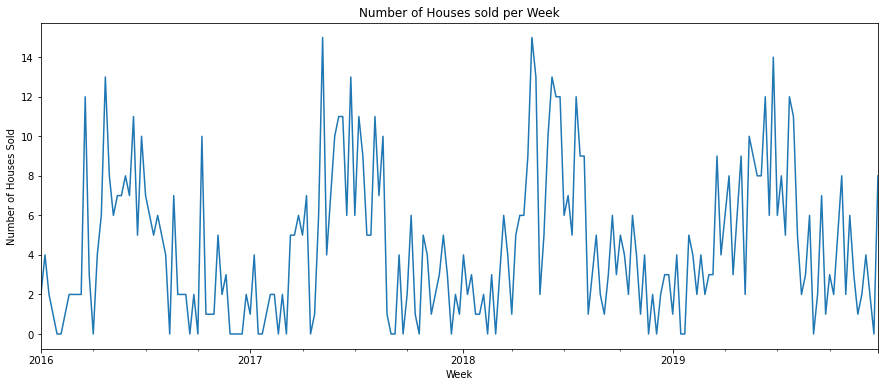

In [38]:
#create a graph of the weekly data
ax = weekly.plot(figsize=(15, 6))
ax.set_xlabel("Week")
ax.set_ylabel("Number of Houses Sold")
ax.set_title("Number of Houses sold per Week")
plt.show()

This graph shows a similar weekly trend for each year. Intially the amount of houses of sold is very low and they pick up around the middle weeks of the year. Again they decrease at the end part of each year. This is in line with the daily graph seen before.

In [39]:
#next do monthly
monthly = soldPerDay.resample("M").sum()
monthly.head()

2016-01-31     9
2016-02-29     5
2016-03-31    19
2016-04-30    31
2016-05-31    28
Freq: M, Name: Date of Sale, dtype: int64

In [40]:
monthly.tail()

2019-08-31    16
2019-09-30    13
2019-10-31    18
2019-11-30    14
2019-12-31    14
Freq: M, Name: Date of Sale, dtype: int64

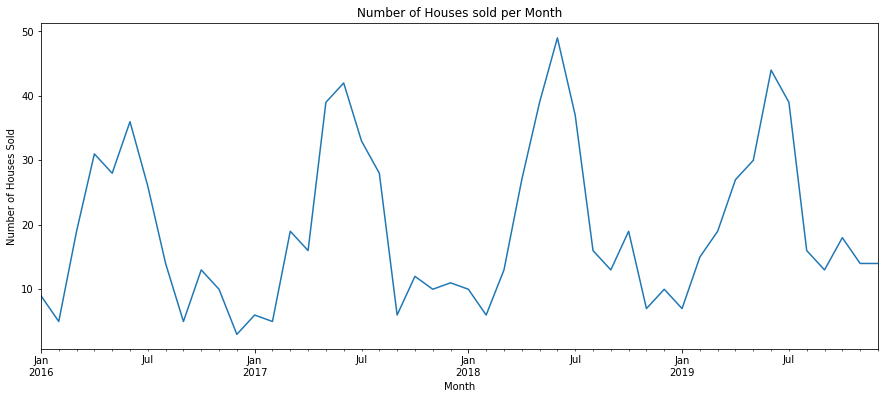

In [41]:
ax = monthly.plot(figsize=(15, 6), use_index = True)
ax.set_xlabel("Month")
ax.set_ylabel("Number of Houses Sold")
ax.set_title("Number of Houses sold per Month")
plt.show()

As seen previously in the weekly graph at during the earlier months a low number of houses are sold then they pick up reaching a peak in June and July before dropping down at the end of the year reaching a low in December.

In [42]:
#next sort by quarter
quarterly = soldPerDay.resample("Q").sum()
quarterly

2016-03-31     33
2016-06-30     95
2016-09-30     45
2016-12-31     26
2017-03-31     30
2017-06-30     97
2017-09-30     67
2017-12-31     33
2018-03-31     29
2018-06-30    115
2018-09-30     66
2018-12-31     36
2019-03-31     41
2019-06-30    101
2019-09-30     68
2019-12-31     46
Freq: Q-DEC, Name: Date of Sale, dtype: int64

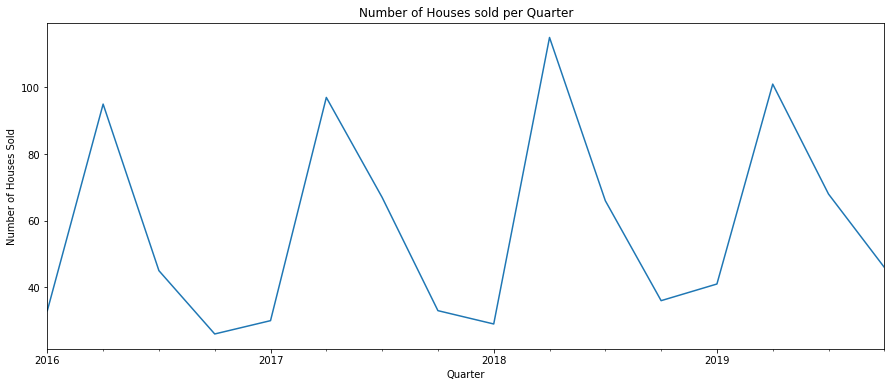

In [43]:
ax = quarterly.plot(figsize=(15, 6), use_index = True)
ax.set_xlabel("Quarter")
ax.set_ylabel("Number of Houses Sold")
ax.set_title("Number of Houses sold per Quarter")
plt.show()

The number of houses sold are at a peak in quarter 2  which includes June and July which we have seen in previous graphs. The trends are same as weekly, daily and monthly samples.

In [44]:
#next get the price of each houses sold
price = pd.Series(ts["Price"], index=ts.index)
price.head()

Date of Sale
2016-01-03    638740
2016-01-03    494549
2016-01-07    546330
2016-01-10    376039
2016-01-10    365696
Name: Price, dtype: int32

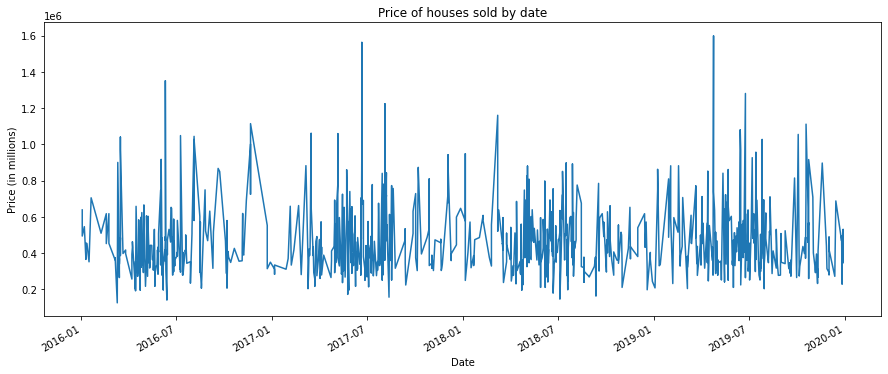

In [45]:
ax = price.plot(figsize=(15, 6), use_index = True)
ax.set_xlabel("Date")
ax.set_ylabel("Price (in millions)")
ax.set_title("Price of houses sold by date")
plt.show()

In [46]:
#next resample by month, rounding to 2 decimal places as it is money
monthlyPrice = round(price.resample("M").mean(), 2)
monthlyPrice.head()

Date of Sale
2016-01-31    487634.22
2016-02-29    530640.20
2016-03-31    489716.05
2016-04-30    398939.19
2016-05-31    382116.14
Freq: M, Name: Price, dtype: float64

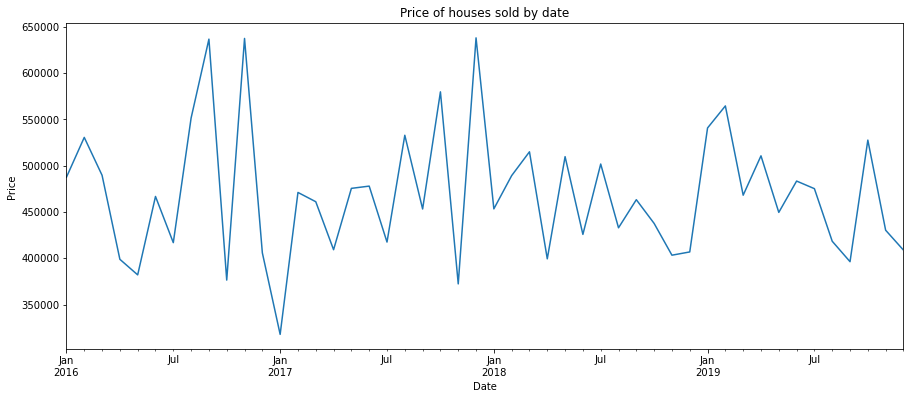

In [47]:
#next plot by month of the year
ax = monthlyPrice.plot(figsize=(15, 6), use_index = True)
plt.ticklabel_format(style='plain', axis='y')
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Price of houses sold by date")
plt.show()

House prices drop throughout the middle months of the year. This would help explain why more houses are sold throughout these months. The higher prices throughout the winter months also explains why the number of houses sold are lower. The peak prices drop dramatically in 2019.

In [48]:
#next get the unique locations in the location column
unique = ts.Location.unique()
unique

array(['Brookville', 'West End', 'Oakbrook', 'Rivermont', 'Beacon Hill',
       'East End', 'Avoca'], dtype=object)

In [49]:
#create a function which for each location it will get the average monthly price of the houses sold
#the function takes the location name
def monthlyPriceLocation(location):
    i = ts[ts["Location"] == location]
    l = pd.Series(i["Price"], index=i.index)
    monthlyPrice = round(l.resample("M").mean(), 2)
    monthlyPrice = monthlyPrice.fillna(0)
    return monthlyPrice
    
    

In [50]:
#create a function which graphs the previous data from the last function. Again it takes the location and the name to print in the title
def graphMonthlyLocation(location, name):
    ax = location.plot(figsize=(15, 6), use_index = True)
    plt.ticklabel_format(style='plain', axis='y')
    ax.set_xlabel("Month")
    ax.set_ylabel("Average Price")
    ax.set_title("Average Monthly Price of houses sold in " + name)
    plt.show()

In [51]:
#call the function for each unique location starting with Brookville
Brookville = monthlyPriceLocation("Brookville")
Brookville.head()

Date of Sale
2016-01-31    596295.25
2016-02-29    564079.00
2016-03-31         0.00
2016-04-30         0.00
2016-05-31    487918.67
Freq: M, Name: Price, dtype: float64

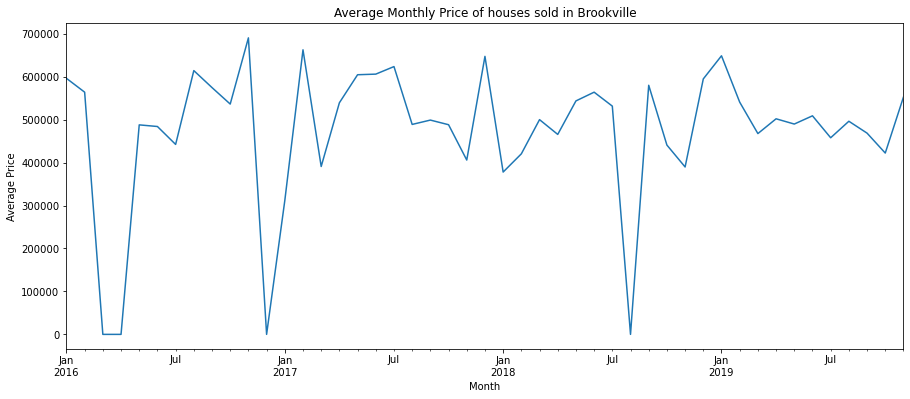

In [52]:
graphMonthlyLocation(Brookville, "Brookville")

The price of houses sold in Brookville are quite consistant. Outside of the months with 0 sold they remain between 400k and 600k with a few peaks near 700k.

In [53]:
WestEnd = monthlyPriceLocation("West End")
WestEnd.head()

Date of Sale
2016-01-31    412806.00
2016-02-29    508347.67
2016-03-31         0.00
2016-04-30    529042.00
2016-05-31    438252.00
Freq: M, Name: Price, dtype: float64

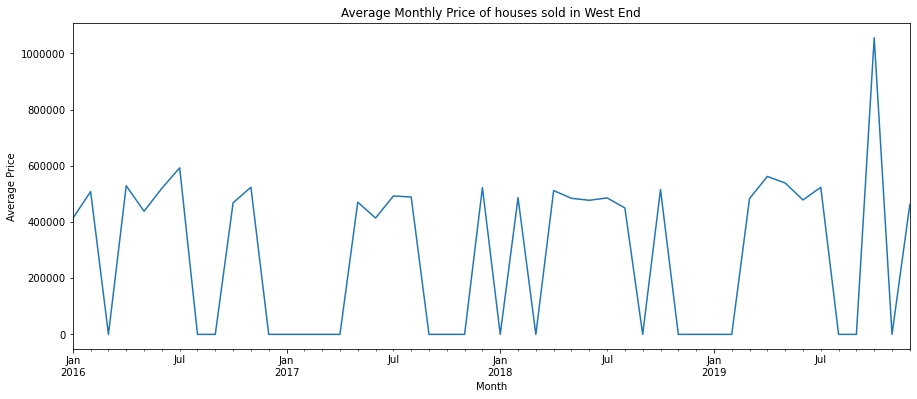

In [54]:
graphMonthlyLocation(WestEnd, "West End")

Houses in West end are incredibly consistant in house prices they are between 400k and 600k when sold. Still there are a lot of months with none sold. There is crazy outlier with one being sold for over 1m which is almost double the rest. 

In [55]:
Oakbrook = monthlyPriceLocation("Oakbrook")
Oakbrook.head()

Date of Sale
2016-01-31    352303.00
2016-02-29         0.00
2016-03-31    380111.43
2016-04-30    399519.80
2016-05-31    361841.00
Freq: M, Name: Price, dtype: float64

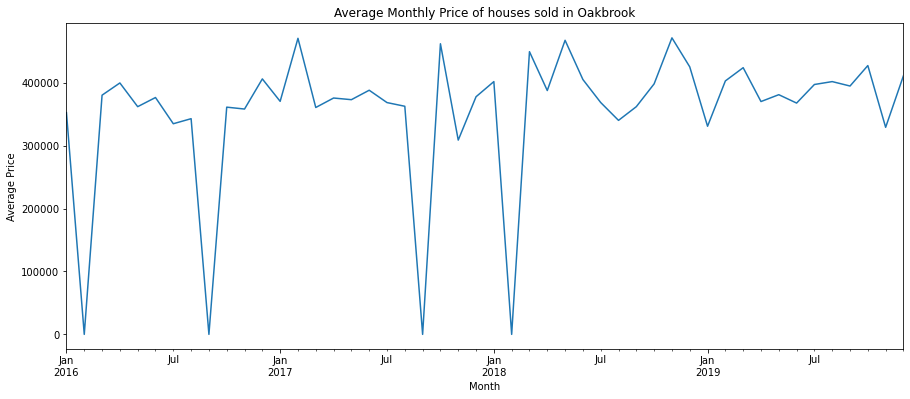

In [56]:
graphMonthlyLocation(Oakbrook, "Oakbrook")

Oakbrook is cheaper than the previous 2 with the max being around 400k compared to 600k and 1m. The house prices peak in the start and of the year. With drops in price around June and July.

In [57]:
Rivermont = monthlyPriceLocation("Rivermont")
Rivermont.head()

Date of Sale
2016-03-31    125854.00
2016-04-30    351006.25
2016-05-31    299583.80
2016-06-30    440551.57
2016-07-31    325592.00
Freq: M, Name: Price, dtype: float64

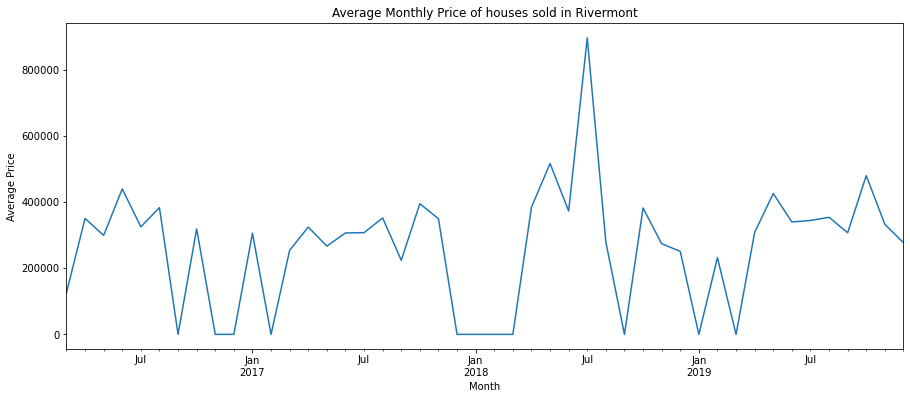

In [58]:
graphMonthlyLocation(Rivermont, "Rivermont")

The prices in Rivermont are similar to Oakbrook but has a peak of 800k in July 2018. This doesn't seem to have an affect on other homes with prices reverting to type afterwards. There seems to be barely any houses sold in Jan with 2 of 3 years not having any sold.

In [59]:
BeaconHill = monthlyPriceLocation("Beacon Hill")
BeaconHill.head()

Date of Sale
2016-03-31    750109.50
2016-04-30         0.00
2016-05-31         0.00
2016-06-30    607292.17
2016-07-31         0.00
Freq: M, Name: Price, dtype: float64

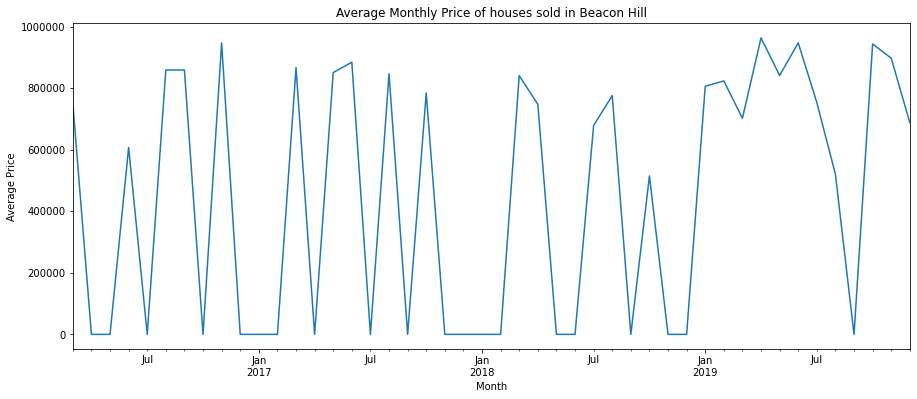

In [60]:
graphMonthlyLocation(BeaconHill, "Beacon Hill")

Beacon Hill is very expensive with most houses ranging between 800k and 1m. These prices explain why there are more months with 0 houses sold compared to the rest. The prices seem to have increased in 2019 with the average price being higher than previous.

In [61]:
EastEnd = monthlyPriceLocation("East End")
EastEnd.head()

Date of Sale
2016-03-31    277524.00
2016-04-30    328739.36
2016-05-31    351741.67
2016-06-30    141115.00
2016-07-31    295249.00
Freq: M, Name: Price, dtype: float64

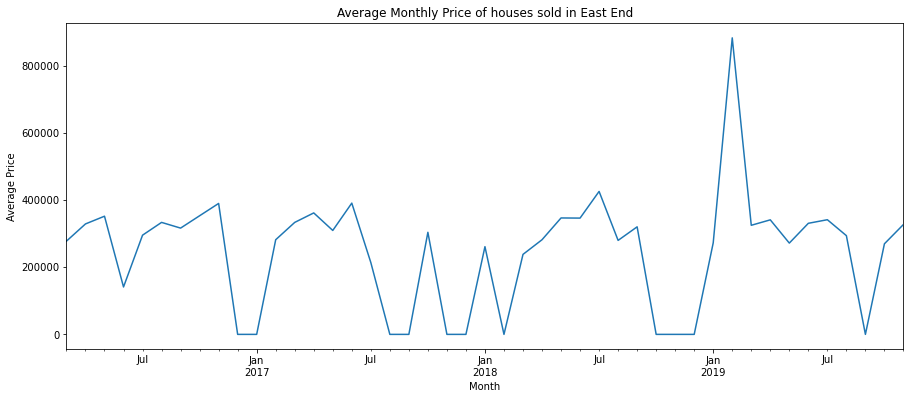

In [62]:
graphMonthlyLocation(EastEnd, "East End")

East end is a cheap area with the average being between 200k and 400k. With a peak of over 800k in February 2019.

In [63]:
avoca = monthlyPriceLocation("Avoca")
avoca.head()

Date of Sale
2016-03-31    487422.00
2016-04-30    550842.67
2016-05-31         0.00
2016-06-30    432909.00
2016-07-31    393259.50
Freq: M, Name: Price, dtype: float64

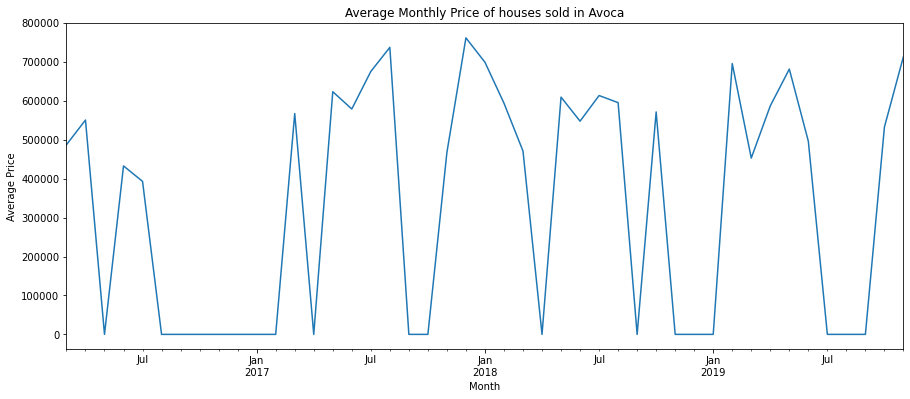

In [64]:
graphMonthlyLocation(avoca, "Avoca")

There is a 6 month period between Aug 2016 to Feb 2017 where there are 0 houses sold. This may be because the prices of these houses are high averaging over 500k and peaking at 800k. 

The price of house drops during the middle of the year. This is also when the number of houses sold peaks. These are obvioulsy correlated as someone is more likely to buy a house when they are cheaper and someone is more likely to sell a house when its is more affordable. 

## Correaltion

First i shall create a correlation table for all numeric features.

In [65]:
ts_c = ts.corr()
ts_c

,Price,Year Built,Size,Stories,Bedrooms,Bathrooms
Price,1.000000,0.558497,0.676384,0.250412,0.192750,0.576748
Year Built,0.558497,1.000000,0.148601,0.189548,-0.058903,0.470016
Size,0.676384,0.148601,1.000000,0.542950,0.544624,0.626552
Stories,0.250412,0.189548,0.542950,1.000000,0.302504,0.428531
Bedrooms,0.192750,-0.058903,0.544624,0.302504,1.000000,0.316518
Bathrooms,0.576748,0.470016,0.626552,0.428531,0.316518,1.000000


In [66]:
#create a table to rank the correlation between each of the values
from itertools import combinations
rows = []
for v1, v2 in combinations(ts_c.columns, 2):
    rows.append({"Variable 1": v1, "Variable 2": v2, "Correlation": ts_c[v1][v2]})
pd.DataFrame(rows).sort_values(by="Correlation", ascending=False)

,Variable 1,Variable 2,Correlation
1,Price,Size,0.676384
11,Size,Bathrooms,0.626552
4,Price,Bathrooms,0.576748
0,Price,Year Built,0.558497
10,Size,Bedrooms,0.544624
9,Size,Stories,0.542950
8,Year Built,Bathrooms,0.470016
13,Stories,Bathrooms,0.428531
14,Bedrooms,Bathrooms,0.316518
12,Stories,Bedrooms,0.302504


As shown above price and size are strongly positively correlated, which is to be expected. The number of bathrooms is also clearly strongly correlated to both the price and the size of a home. Also shown is that the year of build is positively correlated to the prcice. Newer builds are also likely to have more bathrooms. Although interestingly the year built and number of bedrooms is negatively correlated.

Next I will look at the correlation between price and the other numeric features.

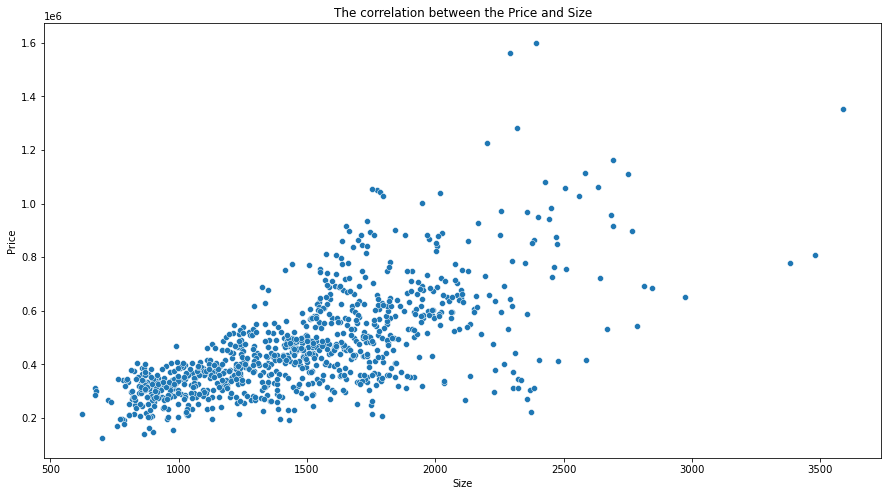

In [67]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=ts, x="Size", y='Price')
plt.title("The correlation between the Price and Size")
plt.show()

Size and Price are strongly positively correlated as seen previously with a correlation of 0.676!

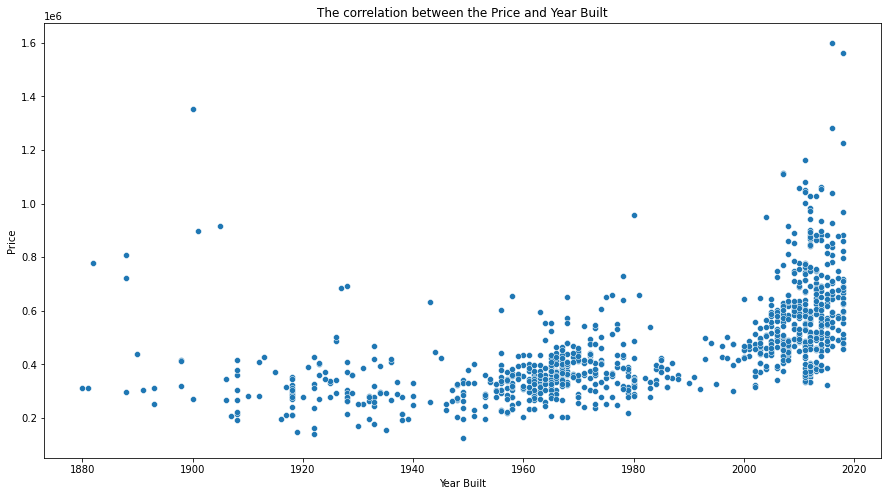

In [68]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=ts, x="Year Built", y='Price')
plt.title("The correlation between the Price and Year Built")
plt.show()

Newer builds are more costly with a lot more houses over 500k which had previouly been an outlier. Houses built between 1880 and 2000 tend to be between 200k and 400k.

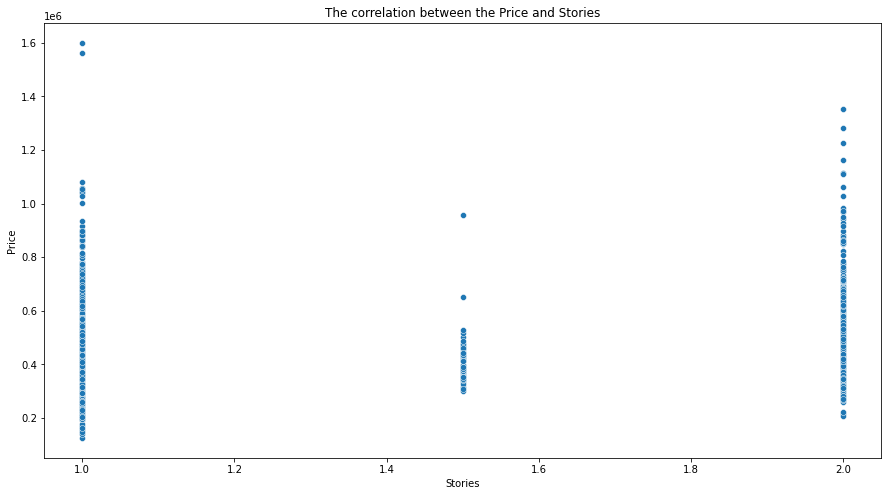

In [69]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=ts, x="Stories", y='Price')
plt.title("The correlation between the Price and Stories")
plt.show()

Outside of 1.5 story houses there does not seem to be much of a difference between the price and number of stories.

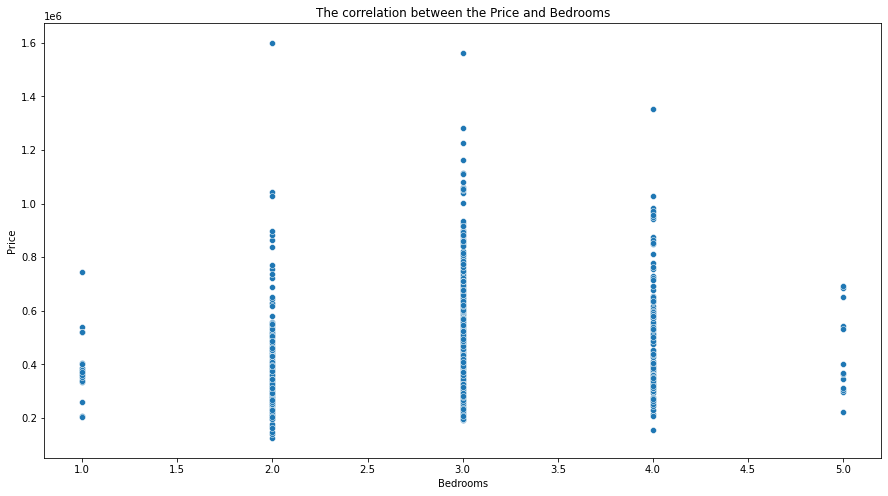

In [70]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=ts, x="Bedrooms", y='Price')
plt.title("The correlation between the Price and Bedrooms")
plt.show()

Perphaps unexpectadely houses with 5 bedrooms are not that expensive although this is surely due to the small sample size. As to be expected those with 2, 3 and 4 bedrooms are similar in price.

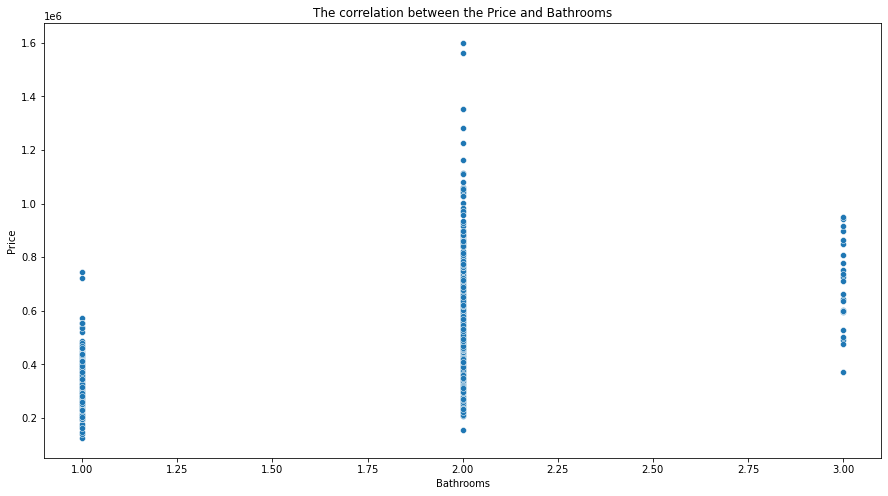

In [71]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=ts, x="Bathrooms", y='Price')
plt.title("The correlation between the Price and Bathrooms")
plt.show()

Clearly most have two bathrooms. Both expensive and cheap mostly have 2 bedrooms. Expectedly those with only 1 bathroom are on the lower end of proce with most being under 400k.

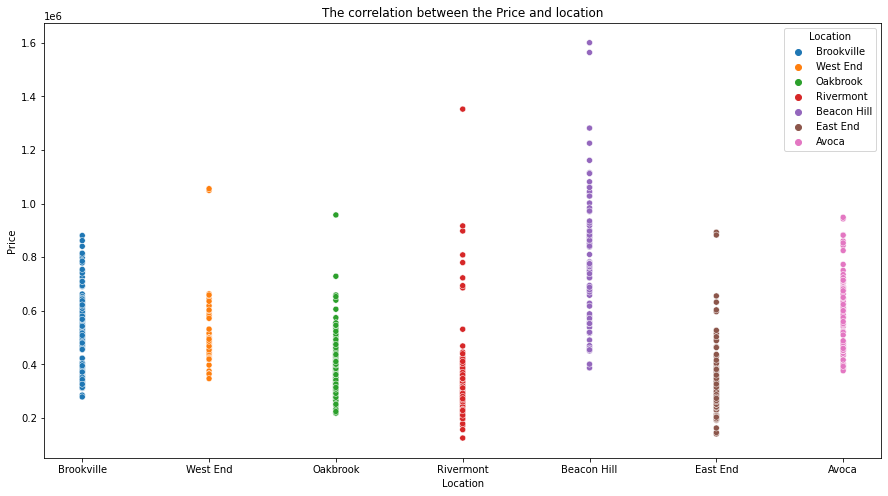

In [72]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=ts, x="Location", y='Price', hue='Location')
plt.title("The correlation between the Price and location")
plt.show()

Beacon hill has the highest distribution of prices starting at 0.4m and ending at 1.6m. West end as seen previously has a clear outlier with a house costing over one million with the rest being between circa 0.3m and 0.6m. Still most of the places are rather consistant

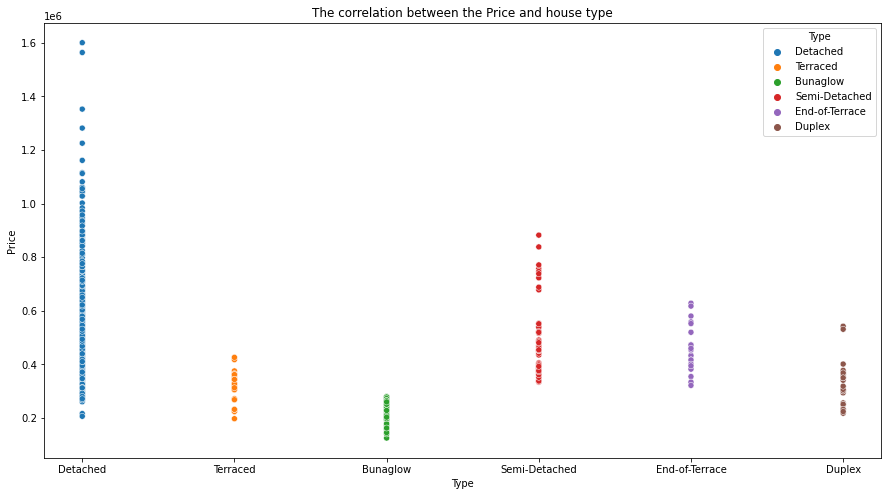

In [73]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=ts, x="Type", y='Price', hue='Type')
plt.title("The correlation between the Price and house type")
plt.show()

There are a lot more detatched houses sold and they have a lot more variance in price compared to all others. The proce varies between 200k and 1.6m! Bungalows tend to be cheaper as expected due to the size of bungalows. Detatched houses also have more space around them through gardens. Which could also explain the higher prices.

## Regression

In [74]:
x = ts[["Size"]].values
y = ts[["Price"]].values
model = LinearRegression()
model.fit(x, y)
print("Model intercept is", model.intercept_)
print("Model slope is", model.coef_[0])

Model intercept is [39991.4998696]
Model slope is [287.1462589]


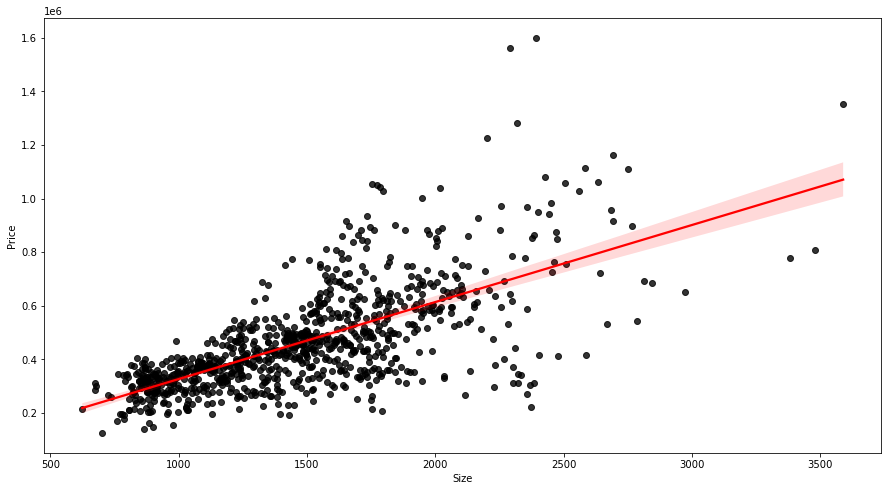

In [75]:
plt.figure(figsize=(15,8))
sns.regplot(data =ts,x="Size", y="Price", scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.show()

In [76]:
#create a test set of the first 5 values in the column and make predictions 
test_x = x[0:5]
predictions = model.predict(test_x)
predictions

array([[570924.93256844],
       [462383.64670572],
       [485355.34741741],
       [348099.43566509],
       [347525.14314729]])

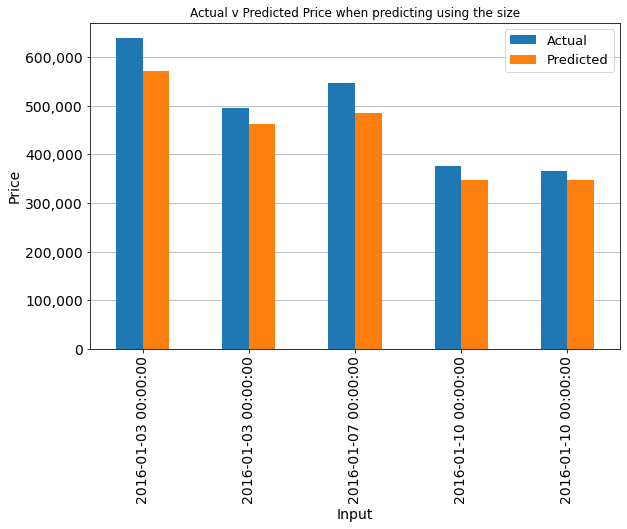

In [77]:
#next i will create a barchart which shows the actual price of the house and the predicted value
df_comparison = pd.DataFrame({'Actual': ts["Price"][0:5], 'Predicted': predictions.flatten()})
ax = df_comparison.plot(kind="bar", figsize=(9.5, 6), fontsize=14, zorder=3)
ax.legend(fontsize=13)
ax.yaxis.grid(True)
ax.yaxis.set_major_formatter("{x:,.0f}");
ax.set_title("Actual v Predicted Price when predicting using the size")
ax.set_xlabel("Input", fontsize=14)
ax.set_ylabel("Price", fontsize=14);

Size is strongly correlated with the price. It is clearly the feature that can be best used to make predictions. Though the model appears to be dragged down by outliers. This is seen in the barchart above as all the predicted atributes are slightly lower than the actual value.

In [78]:
# Get the columns
x = ts[["Year Built"]].values
y = ts[["Price"]].values
# Now build the regression model
model = LinearRegression()
model.fit(x, y)
print("Model intercept is", model.intercept_)
print("Model slope is", model.coef_[0])

Model intercept is [-6062027.24755959]
Model slope is [3294.98293608]


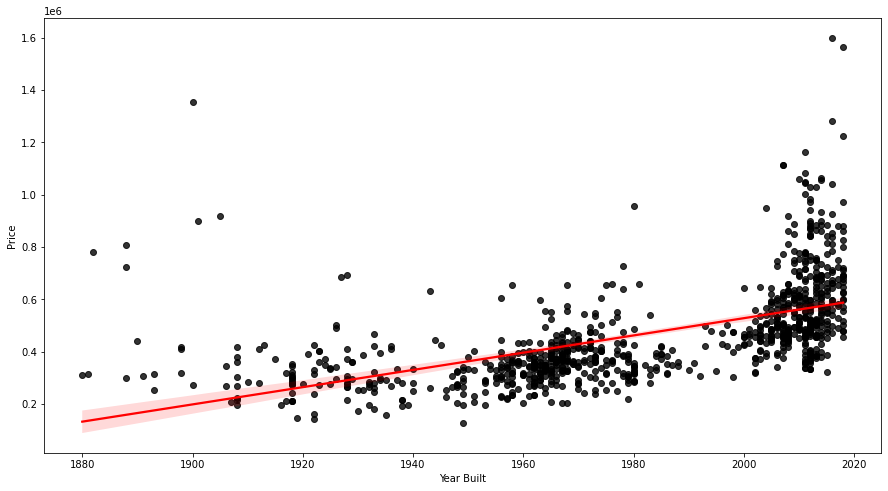

In [79]:
plt.figure(figsize=(15,8))
sns.regplot(data =ts,x="Year Built", y="Price", scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.show()

In [80]:
#again make predictions
test_x = x[0:5]
predictions = model.predict(test_x)
predictions

array([[564183.43689527],
       [557593.47102312],
       [557593.47102312],
       [406024.25596348],
       [392844.32421917]])

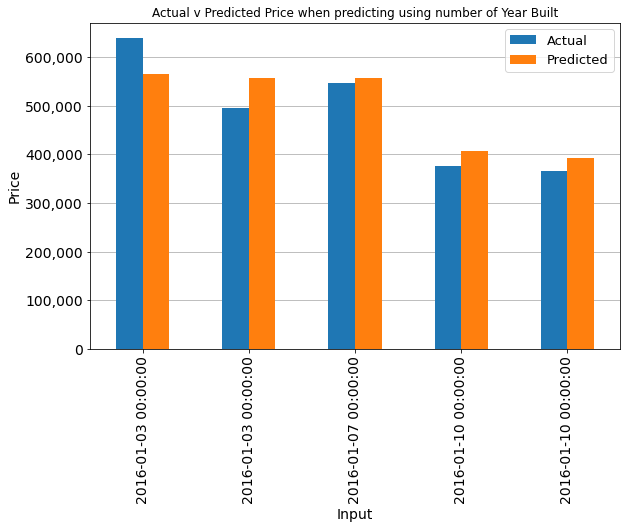

In [81]:
#plot the predicted value and the actual value
df_comparison = pd.DataFrame({'Actual': ts["Price"][0:5], 'Predicted': predictions.flatten()})
ax = df_comparison.plot(kind="bar", figsize=(9.5, 6), fontsize=14, zorder=3)
ax.legend(fontsize=13)
ax.yaxis.grid(True)
ax.yaxis.set_major_formatter("{x:,.0f}");
ax.set_title("Actual v Predicted Price when predicting using number of Year Built")
ax.set_xlabel("Input", fontsize=14)
ax.set_ylabel("Price", fontsize=14);

As previoulsy seen year built and price and positively correlated. The ability to predict is flawed however. For example there are a lot of builds in the 2000s that are way under the prediction for the size. For example a house built in 2000 is expected to be 800k yet the majority of such builds are under that price. As seen in the barchart it appears to consistently overpredict the prices of the first 5 houses.

In [82]:
# Get the columns
x = ts[["Stories"]].values
y = ts[["Price"]].values
# Now build the regression model
model = LinearRegression()
model.fit(x, y)
print("Model intercept is", model.intercept_)
print("Model slope is", model.coef_[0])

Model intercept is [325163.07427606]
Model slope is [101675.3725592]


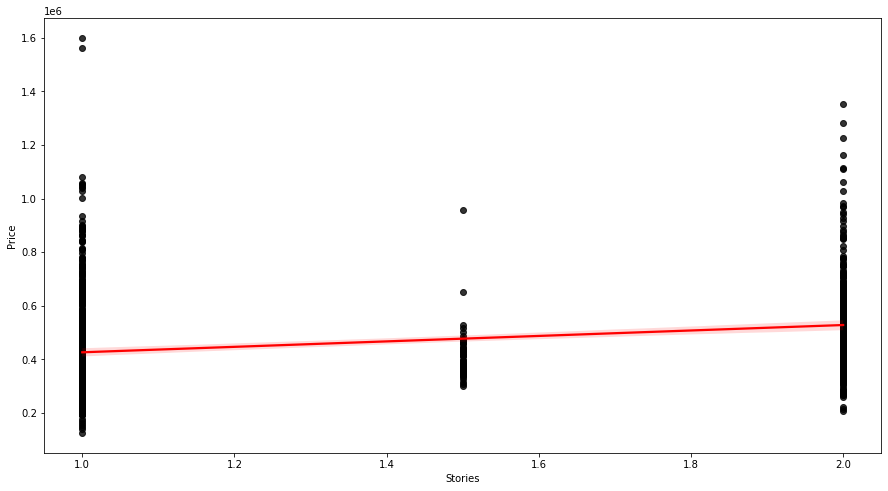

In [83]:
plt.figure(figsize=(15,8))
sns.regplot(data =ts,x="Stories", y="Price", scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.show()

In [84]:
test_x = x[0:5]
predictions = model.predict(test_x)
predictions

array([[528513.81939446],
       [426838.44683526],
       [426838.44683526],
       [426838.44683526],
       [426838.44683526]])

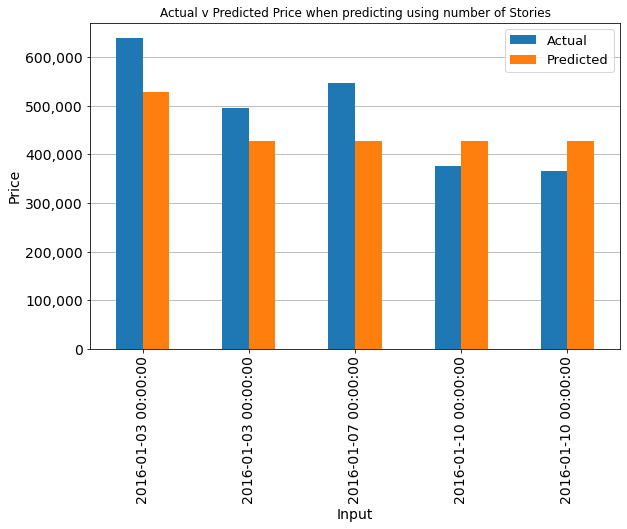

In [85]:
df_comparison = pd.DataFrame({'Actual': ts["Price"][0:5], 'Predicted': predictions.flatten()})
ax = df_comparison.plot(kind="bar", figsize=(9.5, 6), fontsize=14, zorder=3)
ax.legend(fontsize=13)
ax.yaxis.grid(True)
ax.yaxis.set_major_formatter("{x:,.0f}");
ax.set_title("Actual v Predicted Price when predicting using number of Stories")
ax.set_xlabel("Input", fontsize=14)
ax.set_ylabel("Price", fontsize=14);

The number of stories is clearly not a good way to predict the price of a house. Since stories have very small differnces in their values (being either 1, 1.5 or 2) it is hard to gain accurate insights. A 2 story house could be the cheapest and the most expensive house. None of the predictions as seen in the barchart are close to the actual values of the house.

In [86]:
# Get the columns
x = ts[["Bathrooms"]].values
y = ts[["Price"]].values
# Now build the regression model
model = LinearRegression()
model.fit(x, y)
print("Model intercept is", model.intercept_)
print("Model slope is", model.coef_[0])

Model intercept is [142861.49122578]
Model slope is [202413.32575659]


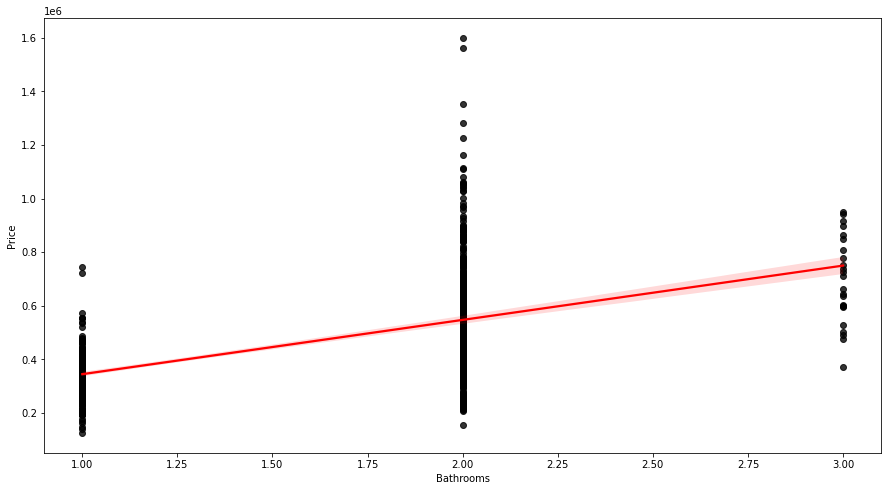

In [87]:
plt.figure(figsize=(15,8))
sns.regplot(data =ts,x="Bathrooms", y="Price", scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.show()

In [88]:
test_x = x[0:5]
predictions = model.predict(test_x)
predictions

array([[547688.14273895],
       [547688.14273895],
       [547688.14273895],
       [345274.81698236],
       [345274.81698236]])

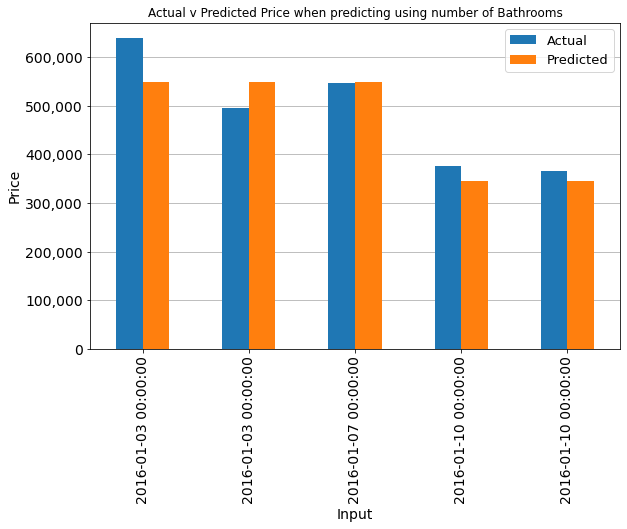

In [89]:
df_comparison = pd.DataFrame({'Actual': ts["Price"][0:5], 'Predicted': predictions.flatten()})
ax = df_comparison.plot(kind="bar", figsize=(9.5, 6), fontsize=14, zorder=3)
ax.legend(fontsize=13)
ax.yaxis.grid(True)
ax.yaxis.set_major_formatter("{x:,.0f}");
ax.set_title("Actual v Predicted Price when predicting using number of Bathrooms")
ax.set_xlabel("Input", fontsize=14)
ax.set_ylabel("Price", fontsize=14);

The number of bathrooms is one of the better ways to predict the house price. There is a positive correlation. Being the third highest at 0.58 as previously seen. All the predictions seen in the barchart are relatively accurate, except for the first one. Still the lac of variance in the data limits its possibilites to make predictions. A house sold for 200k and one sold for 1.6m both have two bathrooms. This could slightly the predictions. As seen in the chart above all predicitions for two bathroom homes appears to be just over 500k. Which would be drastically wrong for 200k and 1.6m

In [90]:
# Get the columns
x = ts[["Bedrooms"]].values
y = ts[["Price"]].values
# Now build the regression model
model = LinearRegression()
model.fit(x, y)
print("Model intercept is", model.intercept_)
print("Model slope is", model.coef_[0])

Model intercept is [315079.93206013]
Model slope is [51881.34565556]


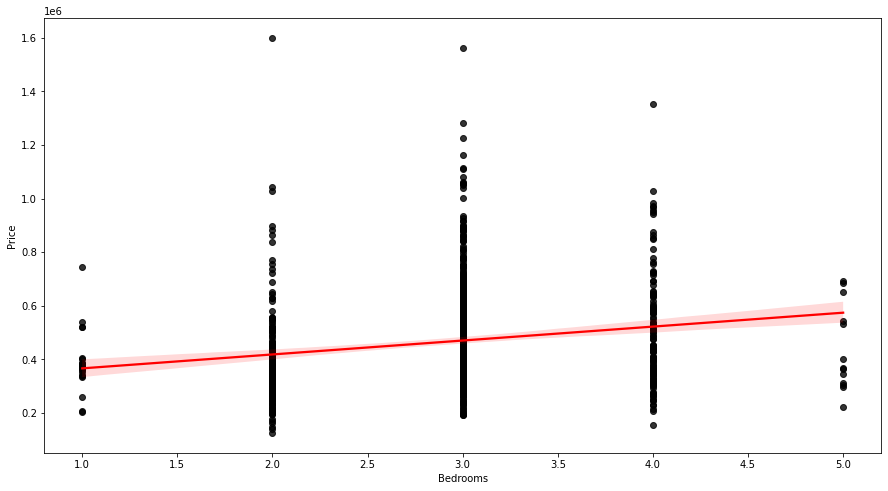

In [91]:
plt.figure(figsize=(15,8))
sns.regplot(data =ts,x="Bedrooms", y="Price", scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.show()

In [92]:
test_x = x[0:5]
predictions = model.predict(test_x)
predictions

array([[470723.9690268],
       [470723.9690268],
       [470723.9690268],
       [470723.9690268],
       [470723.9690268]])

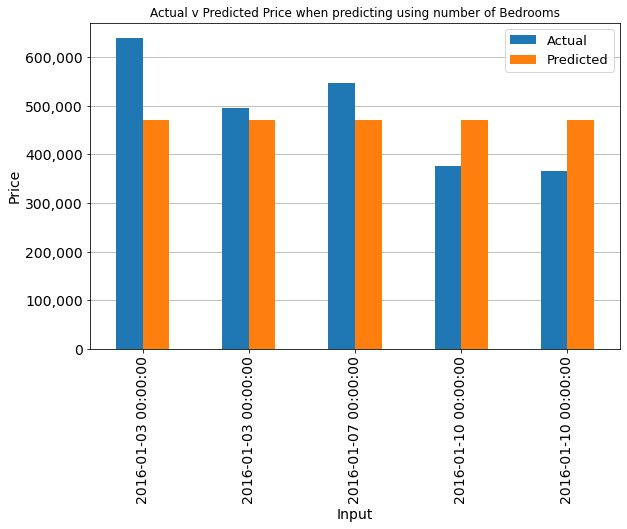

In [93]:
df_comparison = pd.DataFrame({'Actual': ts["Price"][0:5], 'Predicted': predictions.flatten()})
ax = df_comparison.plot(kind="bar", figsize=(9.5, 6), fontsize=14, zorder=3)
ax.legend(fontsize=13)
ax.yaxis.grid(True)
ax.yaxis.set_major_formatter("{x:,.0f}");
ax.set_xlabel("Input", fontsize=14)
ax.set_title("Actual v Predicted Price when predicting using number of Bedrooms")
ax.set_ylabel("Price", fontsize=14);

The number of bedrooms is clearly not a good way to predict the price based on the above barchart. This is also seen due to the correlation of just 0.19! All the 5 samples shown above have the same number of bedrooms, so the model makes the same predicition for all and as we can see this is clearly not accurate.

Clearly the size of the house is the best attribute to use when making predicitons for the price of the house. It has less shortcomings than bedrooms and stories due to the variance in values. This allows the model  to make a more accurate prediciton.

## Classification

In [94]:
#first count the values for each
ts["Location"].value_counts()

Oakbrook       236
Brookville     170
Rivermont      128
East End       121
West End       100
Avoca           93
Beacon Hill     80
Name: Location, dtype: int64

In [95]:
#make location the target as we are trying to predict the location based on different attributes
target = ts["Location"].values

## Price Classification

In [96]:
#make price the data as we will be trying to see can we use price to predict the location
data = ts[["Price"]]
data.head()

,Price
Date of Sale,
2016-01-03,638740
2016-01-03,494549
2016-01-07,546330
2016-01-10,376039
2016-01-10,365696


In [97]:
#normalise and scale the data between 0 and 1. This will become more useful when using multiple columns with different ranges
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
#use k nearest neighbours to classify intially with n = 1
knn = KNeighborsClassifier(n_neighbors=1)
#use all the scaled values and the all the target values
m = knn.fit(data_scaled, target)
#assign a value for price that will be used to predict
location1 = [17203946]
#apply the same normaliser as before
unseen_data = np.array([location1])
unseen_scaled = normalizer.transform(unseen_data)
#use knn to predict 
prediction = knn.predict(unseen_scaled)
prediction[0]

'Beacon Hill'

To evaluate the effectiveness of our KNN classifier on the Price data, I will randomly split the complete dataset into a training test and an unseen test set. I will specify that 30% (0.3) of the data will be used for the test set.

In [98]:
# use 70% for training, 30% for testing
data_train, data_test, target_train, target_test = train_test_split(data_scaled, target, 
    test_size=0.3, random_state=1)
print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])

Training set has 649 examples
Test set has 279 examples


Train the model using the training set.

In [99]:
model = KNeighborsClassifier(n_neighbors=1)
m = model.fit(data_train, target_train)

In [100]:
predicted = model.predict(data_test)
# print the predictions
print("Predictions:\n%s" % predicted)
# print the number of predictions from each class
print("\nClass counts:\n%s" % pd.Series(predicted).value_counts())

Predictions:
['Beacon Hill' 'Beacon Hill' 'Oakbrook' 'East End' 'Rivermont' 'Oakbrook'
 'East End' 'Brookville' 'Oakbrook' 'East End' 'Avoca' 'Oakbrook'
 'Beacon Hill' 'Oakbrook' 'Brookville' 'East End' 'Avoca' 'West End'
 'Brookville' 'Oakbrook' 'Rivermont' 'Rivermont' 'Brookville' 'Avoca'
 'Oakbrook' 'Rivermont' 'West End' 'Oakbrook' 'Avoca' 'West End'
 'Rivermont' 'Avoca' 'Avoca' 'East End' 'East End' 'East End' 'Rivermont'
 'Rivermont' 'Brookville' 'West End' 'Beacon Hill' 'Rivermont' 'Oakbrook'
 'Oakbrook' 'East End' 'Brookville' 'Oakbrook' 'Brookville' 'Rivermont'
 'Rivermont' 'East End' 'Brookville' 'West End' 'Brookville' 'East End'
 'Oakbrook' 'Oakbrook' 'Oakbrook' 'Rivermont' 'Oakbrook' 'East End'
 'Oakbrook' 'West End' 'Avoca' 'Oakbrook' 'Oakbrook' 'Oakbrook' 'Oakbrook'
 'West End' 'West End' 'Rivermont' 'West End' 'Oakbrook' 'Oakbrook'
 'West End' 'West End' 'Oakbrook' 'Avoca' 'Beacon Hill' 'Rivermont'
 'Oakbrook' 'Rivermont' 'Oakbrook' 'Rivermont' 'Avoca' 'Rivermont' 'Avoc

In [101]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.265


Clearly with an accuracy value of 0.265. Price is not very good at predicting location. As we have seen before a number of locations have very similar price ranges so it could be difficult to predict.

In [102]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.265
K=02 neighbours: Accuracy=0.297
K=03 neighbours: Accuracy=0.294
K=04 neighbours: Accuracy=0.351
K=05 neighbours: Accuracy=0.333
K=06 neighbours: Accuracy=0.384
K=07 neighbours: Accuracy=0.358
K=08 neighbours: Accuracy=0.401
K=09 neighbours: Accuracy=0.405
K=10 neighbours: Accuracy=0.401
K=11 neighbours: Accuracy=0.416
K=12 neighbours: Accuracy=0.427
K=13 neighbours: Accuracy=0.430
K=14 neighbours: Accuracy=0.437
K=15 neighbours: Accuracy=0.434


Clearly though increasing the value for K produces more accurate predictions. The peak being K = 14. 

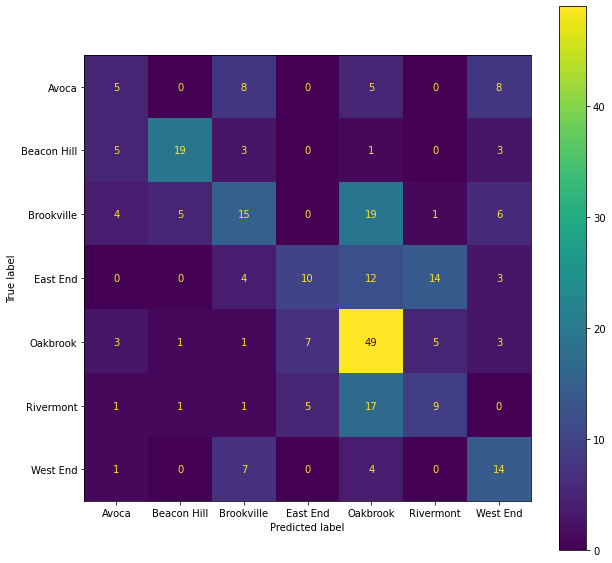

In [103]:
# next i will create a confusion matrix to tell us where the classification is making the most mistakes.
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

The model appears to be most accurate for oakbrook. With 49 predictions being correct. Still there are a huge number of mistakes. In an accurate classifier the diagonal would be more prominent than is seen here.

In [104]:
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.26      0.19      0.22        26
 Beacon Hill       0.73      0.61      0.67        31
  Brookville       0.38      0.30      0.34        50
    East End       0.45      0.23      0.31        43
    Oakbrook       0.46      0.71      0.56        69
   Rivermont       0.31      0.26      0.29        34
    West End       0.38      0.54      0.44        26

    accuracy                           0.43       279
   macro avg       0.43      0.41      0.40       279
weighted avg       0.43      0.43      0.42       279



This classification report tells us that it is most accurate in prediciting for Beacon Hill and is not accurate at prediciting avoca. Though Oakbrook has the highest recall value. Which is for all instances that were actually positive, what percent was classified correctly. 

## Year Bulit Classification

All code is the same as previous just with a change in the data table from price to Year Built

In [105]:
data = ts[["Year Built"]]
data.head()

,Year Built
Date of Sale,
2016-01-03,2011
2016-01-03,2009
2016-01-07,2009
2016-01-10,1963
2016-01-10,1959


In [106]:
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
knn = KNeighborsClassifier(n_neighbors=1)
m = knn.fit(data_scaled, target)
location1 = [2005]
unseen_data = np.array([location1])
# apply the same min-max- normalisation as before
unseen_scaled = normalizer.transform(unseen_data)
prediction = knn.predict(unseen_scaled)
prediction[0]

'West End'

In [107]:
# use 70% for training, 30% for testing
data_train, data_test, target_train, target_test = train_test_split(data_scaled, target, 
    test_size=0.3, random_state=1)
print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])

Training set has 649 examples
Test set has 279 examples


In [108]:
model = KNeighborsClassifier(n_neighbors=1)
m = model.fit(data_train, target_train)

In [109]:
predicted = model.predict(data_test)

In [110]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.459


The year built is more accurate than the Price and this could be due to different areas being built at completely different times. Therefore if all houses in one area where built in the same year it would be easy to predict. Still it is less than 0.50 as an accuracy score. 

In [111]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.459
K=02 neighbours: Accuracy=0.459
K=03 neighbours: Accuracy=0.491
K=04 neighbours: Accuracy=0.523
K=05 neighbours: Accuracy=0.509
K=06 neighbours: Accuracy=0.538
K=07 neighbours: Accuracy=0.527
K=08 neighbours: Accuracy=0.534
K=09 neighbours: Accuracy=0.530
K=10 neighbours: Accuracy=0.534
K=11 neighbours: Accuracy=0.545
K=12 neighbours: Accuracy=0.498
K=13 neighbours: Accuracy=0.538
K=14 neighbours: Accuracy=0.534
K=15 neighbours: Accuracy=0.545


knn is most accurate at 15 and 11.

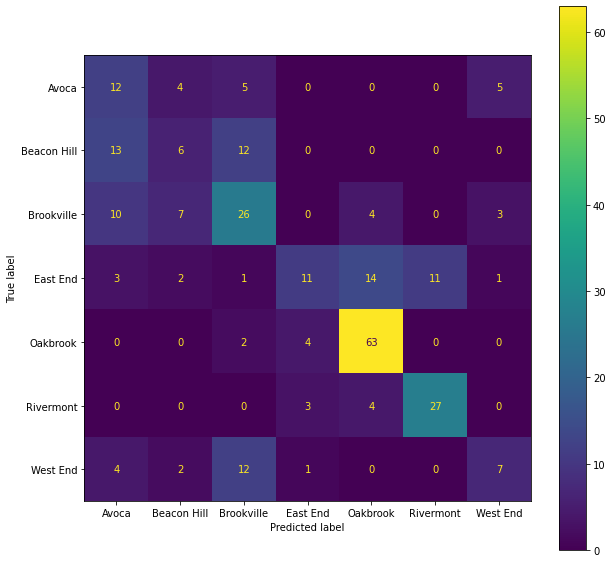

In [112]:
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [113]:
# note we get the labels (names) for the classes from the classifier
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.29      0.46      0.35        26
 Beacon Hill       0.29      0.19      0.23        31
  Brookville       0.45      0.52      0.48        50
    East End       0.58      0.26      0.35        43
    Oakbrook       0.74      0.91      0.82        69
   Rivermont       0.71      0.79      0.75        34
    West End       0.44      0.27      0.33        26

    accuracy                           0.54       279
   macro avg       0.50      0.49      0.47       279
weighted avg       0.54      0.54      0.52       279



It is most accurate at predictiong Oakbrook with a f1-score of 0.82. This would suggest moat Oakbrook houses were built at a similar time. Unlike Price this model is not good at predicting for Beacon Hill which would suggest the prices in the area would be distinct which we have seen previously as higher than the others. 

## Size Classification

In [114]:
data = ts[["Size"]]
data.head()

,Size
Date of Sale,
2016-01-03,1849
2016-01-03,1471
2016-01-07,1551
2016-01-10,1073
2016-01-10,1071


In [115]:
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
knn = KNeighborsClassifier(n_neighbors=1)
m = knn.fit(data_scaled, target)
location1 = [2000]
unseen_data = np.array([location1])
# apply the same min-max- normalisation as before
unseen_scaled = normalizer.transform(unseen_data)
prediction = knn.predict(unseen_scaled)
prediction[0]

'Avoca'

In [116]:
# use 70% for training, 30% for testing
data_train, data_test, target_train, target_test = train_test_split(data_scaled, target, 
    test_size=0.3, random_state=1)
print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])

Training set has 649 examples
Test set has 279 examples


In [117]:
model = KNeighborsClassifier(n_neighbors=1)
m = model.fit(data_train, target_train)

In [118]:
predicted = model.predict(data_test)
# print the predictions
print("Predictions:\n%s" % predicted)
# print the number of predictions from each class
print("\nClass counts:\n%s" % pd.Series(predicted).value_counts())

Predictions:
['Rivermont' 'Avoca' 'West End' 'Rivermont' 'West End' 'Oakbrook'
 'Brookville' 'Oakbrook' 'Brookville' 'East End' 'Beacon Hill' 'East End'
 'Avoca' 'Oakbrook' 'Oakbrook' 'Brookville' 'Avoca' 'Rivermont' 'Oakbrook'
 'East End' 'Brookville' 'Rivermont' 'Avoca' 'Avoca' 'Brookville'
 'Oakbrook' 'Avoca' 'Brookville' 'East End' 'Oakbrook' 'Beacon Hill'
 'Oakbrook' 'West End' 'Avoca' 'Oakbrook' 'Brookville' 'Oakbrook'
 'Brookville' 'Brookville' 'Beacon Hill' 'Oakbrook' 'Rivermont' 'Oakbrook'
 'Oakbrook' 'East End' 'Oakbrook' 'Brookville' 'West End' 'West End'
 'Oakbrook' 'Oakbrook' 'Avoca' 'Oakbrook' 'Avoca' 'Oakbrook' 'Brookville'
 'East End' 'East End' 'Oakbrook' 'Avoca' 'East End' 'Avoca' 'Oakbrook'
 'Beacon Hill' 'Brookville' 'East End' 'Beacon Hill' 'Avoca' 'Avoca'
 'West End' 'Oakbrook' 'Oakbrook' 'East End' 'Rivermont' 'Avoca'
 'Oakbrook' 'Rivermont' 'Rivermont' 'Oakbrook' 'Avoca' 'West End'
 'East End' 'Rivermont' 'Rivermont' 'Oakbrook' 'West End' 'Rivermont'
 'Oakbrook'

In [119]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.233


Size is the least accurate prediciton attribute with a small accuracy score of 0.233

In [120]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.233
K=02 neighbours: Accuracy=0.229
K=03 neighbours: Accuracy=0.222
K=04 neighbours: Accuracy=0.208
K=05 neighbours: Accuracy=0.247
K=06 neighbours: Accuracy=0.251
K=07 neighbours: Accuracy=0.251
K=08 neighbours: Accuracy=0.269
K=09 neighbours: Accuracy=0.251
K=10 neighbours: Accuracy=0.254
K=11 neighbours: Accuracy=0.254
K=12 neighbours: Accuracy=0.265
K=13 neighbours: Accuracy=0.244
K=14 neighbours: Accuracy=0.233
K=15 neighbours: Accuracy=0.265


K = 08 is the most accurate with a score of 0.268 but still this is a poor score.

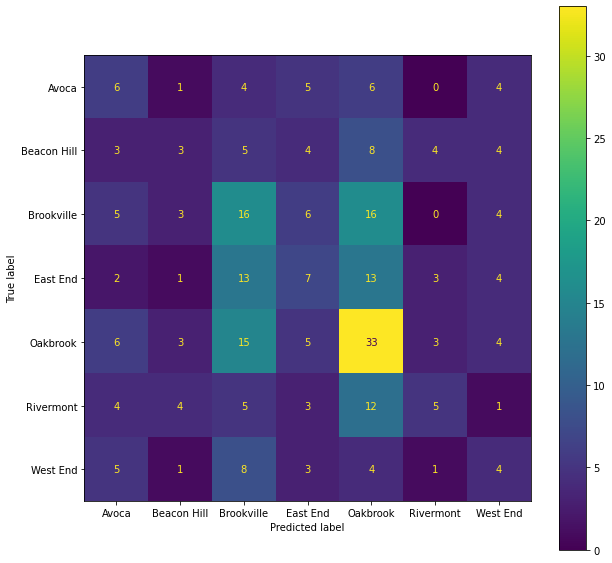

In [121]:
# note we get the labels (names) for the classes from the classifier
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [122]:
# note we get the labels (names) for the classes from the classifier
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.19      0.23      0.21        26
 Beacon Hill       0.19      0.10      0.13        31
  Brookville       0.24      0.32      0.28        50
    East End       0.21      0.16      0.18        43
    Oakbrook       0.36      0.48      0.41        69
   Rivermont       0.31      0.15      0.20        34
    West End       0.16      0.15      0.16        26

    accuracy                           0.27       279
   macro avg       0.24      0.23      0.22       279
weighted avg       0.26      0.27      0.25       279



This clearly shows that it is not very precise. Oakbrook which has normally been a much higher score in all is still the highest but at a much lower value. Still Size is clearly not a very useful attribute to classify the location.

## Story classification

In [123]:
data = ts[["Stories"]]
data.head()

,Stories
Date of Sale,
2016-01-03,2.0
2016-01-03,1.0
2016-01-07,1.0
2016-01-10,1.0
2016-01-10,1.0


In [124]:
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
knn = KNeighborsClassifier(n_neighbors=1)
m = knn.fit(data_scaled, target)
location1 = [2]
unseen_data = np.array([location1])
# apply the same min-max- normalisation as before
unseen_scaled = normalizer.transform(unseen_data)
prediction = knn.predict(unseen_scaled)
prediction[0]

'West End'

In [125]:
model = KNeighborsClassifier(n_neighbors=1)
m = model.fit(data_train, target_train)

In [126]:
predicted = model.predict(data_test)
# print the predictions
print("Predictions:\n%s" % predicted)
# print the number of predictions from each class
print("\nClass counts:\n%s" % pd.Series(predicted).value_counts())

Predictions:
['Rivermont' 'Avoca' 'West End' 'Rivermont' 'West End' 'Oakbrook'
 'Brookville' 'Oakbrook' 'Brookville' 'East End' 'Beacon Hill' 'East End'
 'Avoca' 'Oakbrook' 'Oakbrook' 'Brookville' 'Avoca' 'Rivermont' 'Oakbrook'
 'East End' 'Brookville' 'Rivermont' 'Avoca' 'Avoca' 'Brookville'
 'Oakbrook' 'Avoca' 'Brookville' 'East End' 'Oakbrook' 'Beacon Hill'
 'Oakbrook' 'West End' 'Avoca' 'Oakbrook' 'Brookville' 'Oakbrook'
 'Brookville' 'Brookville' 'Beacon Hill' 'Oakbrook' 'Rivermont' 'Oakbrook'
 'Oakbrook' 'East End' 'Oakbrook' 'Brookville' 'West End' 'West End'
 'Oakbrook' 'Oakbrook' 'Avoca' 'Oakbrook' 'Avoca' 'Oakbrook' 'Brookville'
 'East End' 'East End' 'Oakbrook' 'Avoca' 'East End' 'Avoca' 'Oakbrook'
 'Beacon Hill' 'Brookville' 'East End' 'Beacon Hill' 'Avoca' 'Avoca'
 'West End' 'Oakbrook' 'Oakbrook' 'East End' 'Rivermont' 'Avoca'
 'Oakbrook' 'Rivermont' 'Rivermont' 'Oakbrook' 'Avoca' 'West End'
 'East End' 'Rivermont' 'Rivermont' 'Oakbrook' 'West End' 'Rivermont'
 'Oakbrook'

In [127]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.233


Stories is also a very bad way to classify the location. As we have seen previously the lack of distinct values limits this. As there are only 3 potential values this is not a good way to predict.

In [128]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.233
K=02 neighbours: Accuracy=0.229
K=03 neighbours: Accuracy=0.222
K=04 neighbours: Accuracy=0.208
K=05 neighbours: Accuracy=0.247
K=06 neighbours: Accuracy=0.251
K=07 neighbours: Accuracy=0.251
K=08 neighbours: Accuracy=0.269
K=09 neighbours: Accuracy=0.251
K=10 neighbours: Accuracy=0.254
K=11 neighbours: Accuracy=0.254
K=12 neighbours: Accuracy=0.265
K=13 neighbours: Accuracy=0.244
K=14 neighbours: Accuracy=0.233
K=15 neighbours: Accuracy=0.265


most accurate at K =08

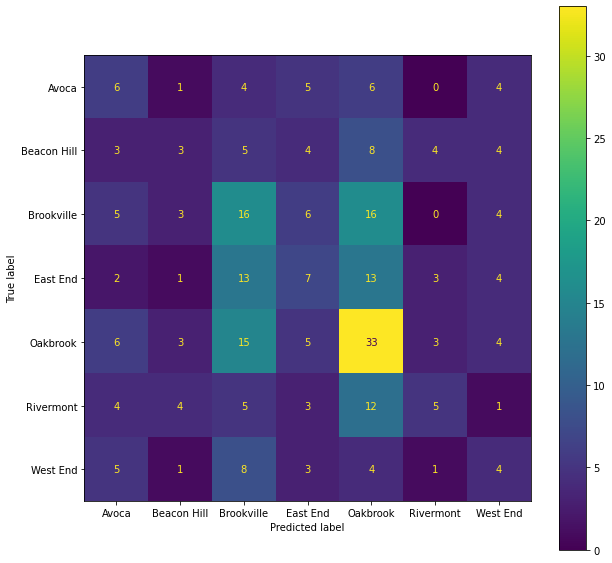

In [129]:
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [130]:
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.19      0.23      0.21        26
 Beacon Hill       0.19      0.10      0.13        31
  Brookville       0.24      0.32      0.28        50
    East End       0.21      0.16      0.18        43
    Oakbrook       0.36      0.48      0.41        69
   Rivermont       0.31      0.15      0.20        34
    West End       0.16      0.15      0.16        26

    accuracy                           0.27       279
   macro avg       0.24      0.23      0.22       279
weighted avg       0.26      0.27      0.25       279



This has the same values as seen in Stories before

## Bedrooms Classification

In [131]:
data = ts[["Bedrooms"]]
data.head()

,Bedrooms
Date of Sale,
2016-01-03,3.0
2016-01-03,3.0
2016-01-07,3.0
2016-01-10,3.0
2016-01-10,3.0


In [132]:
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
knn = KNeighborsClassifier(n_neighbors=1)
m = knn.fit(data_scaled, target)
location1 = [6]
unseen_data = np.array([location1])
# apply the same min-max- normalisation as before
unseen_scaled = normalizer.transform(unseen_data)
prediction = knn.predict(unseen_scaled)
prediction[0]

'Rivermont'

In [133]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.265


Slightly more accurate than the others but as it has the same shortcomings, lack of variation, it is very thought to use this to make predicitons

In [134]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.233
K=02 neighbours: Accuracy=0.229
K=03 neighbours: Accuracy=0.222
K=04 neighbours: Accuracy=0.208
K=05 neighbours: Accuracy=0.247
K=06 neighbours: Accuracy=0.251
K=07 neighbours: Accuracy=0.251
K=08 neighbours: Accuracy=0.269
K=09 neighbours: Accuracy=0.251
K=10 neighbours: Accuracy=0.254
K=11 neighbours: Accuracy=0.254
K=12 neighbours: Accuracy=0.265
K=13 neighbours: Accuracy=0.244
K=14 neighbours: Accuracy=0.233
K=15 neighbours: Accuracy=0.265


most accurate at k = 12 and 15

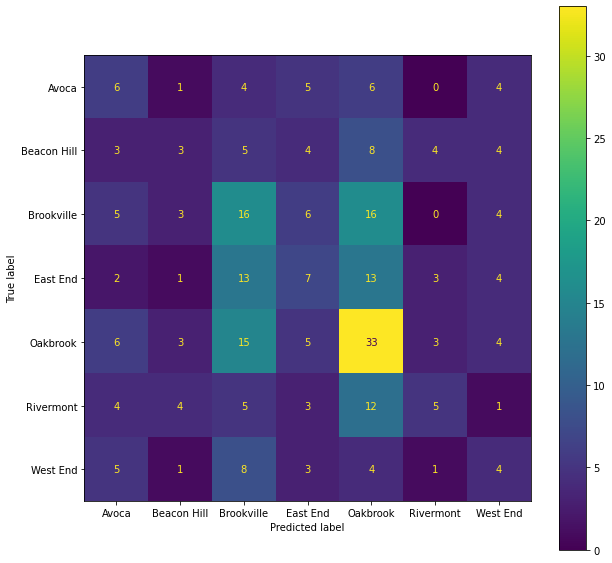

In [135]:
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [136]:
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.19      0.23      0.21        26
 Beacon Hill       0.19      0.10      0.13        31
  Brookville       0.24      0.32      0.28        50
    East End       0.21      0.16      0.18        43
    Oakbrook       0.36      0.48      0.41        69
   Rivermont       0.31      0.15      0.20        34
    West End       0.16      0.15      0.16        26

    accuracy                           0.27       279
   macro avg       0.24      0.23      0.22       279
weighted avg       0.26      0.27      0.25       279



Very poor at predicting across the board with 0.36 being the most precise predicitons which is very low.

## Bathrooms Classification

In [137]:
data = ts[["Bathrooms"]]
data.head()

,Bathrooms
Date of Sale,
2016-01-03,2.0
2016-01-03,2.0
2016-01-07,2.0
2016-01-10,1.0
2016-01-10,1.0


In [138]:
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
knn = KNeighborsClassifier(n_neighbors=1)
m = knn.fit(data_scaled, target)
location1 = [1]
unseen_data = np.array([location1])
# apply the same min-max- normalisation as before
unseen_scaled = normalizer.transform(unseen_data)
prediction = knn.predict(unseen_scaled)
prediction[0]

'Oakbrook'

In [139]:
model = KNeighborsClassifier(n_neighbors=1)
m = model.fit(data_train, target_train)

In [140]:
predicted = model.predict(data_test)
# print the predictions
print("Predictions:\n%s" % predicted)
# print the number of predictions from each class
print("\nClass counts:\n%s" % pd.Series(predicted).value_counts())

Predictions:
['Rivermont' 'Avoca' 'West End' 'Rivermont' 'West End' 'Oakbrook'
 'Brookville' 'Oakbrook' 'Brookville' 'East End' 'Beacon Hill' 'East End'
 'Avoca' 'Oakbrook' 'Oakbrook' 'Brookville' 'Avoca' 'Rivermont' 'Oakbrook'
 'East End' 'Brookville' 'Rivermont' 'Avoca' 'Avoca' 'Brookville'
 'Oakbrook' 'Avoca' 'Brookville' 'East End' 'Oakbrook' 'Beacon Hill'
 'Oakbrook' 'West End' 'Avoca' 'Oakbrook' 'Brookville' 'Oakbrook'
 'Brookville' 'Brookville' 'Beacon Hill' 'Oakbrook' 'Rivermont' 'Oakbrook'
 'Oakbrook' 'East End' 'Oakbrook' 'Brookville' 'West End' 'West End'
 'Oakbrook' 'Oakbrook' 'Avoca' 'Oakbrook' 'Avoca' 'Oakbrook' 'Brookville'
 'East End' 'East End' 'Oakbrook' 'Avoca' 'East End' 'Avoca' 'Oakbrook'
 'Beacon Hill' 'Brookville' 'East End' 'Beacon Hill' 'Avoca' 'Avoca'
 'West End' 'Oakbrook' 'Oakbrook' 'East End' 'Rivermont' 'Avoca'
 'Oakbrook' 'Rivermont' 'Rivermont' 'Oakbrook' 'Avoca' 'West End'
 'East End' 'Rivermont' 'Rivermont' 'Oakbrook' 'West End' 'Rivermont'
 'Oakbrook'

In [141]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.233


Again, very poor accuracy. Same shortcomings as previously seen

In [142]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.233
K=02 neighbours: Accuracy=0.229
K=03 neighbours: Accuracy=0.222
K=04 neighbours: Accuracy=0.208
K=05 neighbours: Accuracy=0.247
K=06 neighbours: Accuracy=0.251
K=07 neighbours: Accuracy=0.251
K=08 neighbours: Accuracy=0.269
K=09 neighbours: Accuracy=0.251
K=10 neighbours: Accuracy=0.254
K=11 neighbours: Accuracy=0.254
K=12 neighbours: Accuracy=0.265
K=13 neighbours: Accuracy=0.244
K=14 neighbours: Accuracy=0.233
K=15 neighbours: Accuracy=0.265


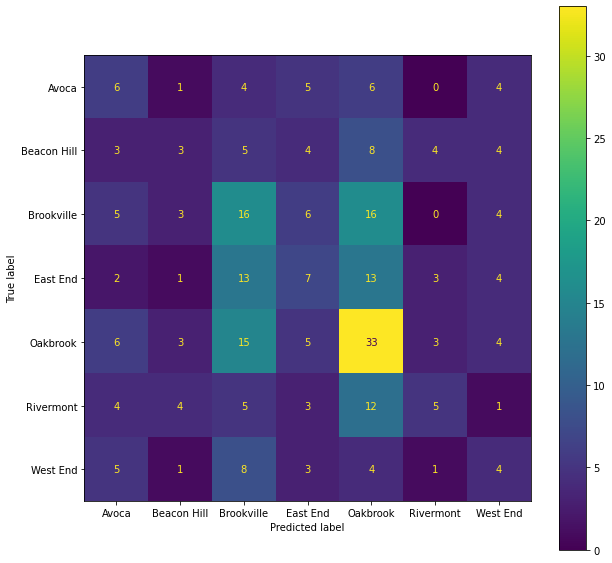

In [143]:
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [144]:
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.19      0.23      0.21        26
 Beacon Hill       0.19      0.10      0.13        31
  Brookville       0.24      0.32      0.28        50
    East End       0.21      0.16      0.18        43
    Oakbrook       0.36      0.48      0.41        69
   Rivermont       0.31      0.15      0.20        34
    West End       0.16      0.15      0.16        26

    accuracy                           0.27       279
   macro avg       0.24      0.23      0.22       279
weighted avg       0.26      0.27      0.25       279



Again Oakbrook the highest. Still only 0.36 which is very poor.

Using only one column to try and classify the location is not very accurate as seen above. With all being under 0.5 on the accuracy score. This tells us we need more information to make accurate classifications which I will now do.

## Classification of multiple columns at a time

### Classification using all numeric features

In [145]:
#first I am going to use all numeric values from ts
data = ts[["Price", "Size", "Year Built", "Stories", "Bathrooms", "Bedrooms"]]
data.head()

,Price,Size,Year Built,Stories,Bathrooms,Bedrooms
Date of Sale,,,,,,
2016-01-03,638740,1849,2011,2.0,2.0,3.0
2016-01-03,494549,1471,2009,1.0,2.0,3.0
2016-01-07,546330,1551,2009,1.0,2.0,3.0
2016-01-10,376039,1073,1963,1.0,1.0,3.0
2016-01-10,365696,1071,1959,1.0,1.0,3.0


In [146]:
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
knn = KNeighborsClassifier(n_neighbors=1)
m = knn.fit(data_scaled, target)
location1 = [172039, 1125, 2012, 2, 1, 4]
unseen_data = np.array([location1])
# apply the same min-max- normalisation as before
unseen_scaled = normalizer.transform(unseen_data)
prediction = knn.predict(unseen_scaled)
prediction[0]

'Oakbrook'

In [147]:
# use 70% for training, 30% for testing
data_train, data_test, target_train, target_test = train_test_split(data_scaled, target, 
    test_size=0.3, random_state=1)
print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])

Training set has 649 examples
Test set has 279 examples


In [148]:
model = KNeighborsClassifier(n_neighbors=1)
m = model.fit(data_train, target_train)

In [149]:
predicted = model.predict(data_test)
# print the predictions
print("Predictions:\n%s" % predicted)
# print the number of predictions from each class
print("\nClass counts:\n%s" % pd.Series(predicted).value_counts())

Predictions:
['Beacon Hill' 'Brookville' 'West End' 'East End' 'East End' 'Avoca'
 'Rivermont' 'Oakbrook' 'West End' 'Brookville' 'Brookville' 'Oakbrook'
 'Beacon Hill' 'East End' 'Beacon Hill' 'Oakbrook' 'Brookville'
 'Brookville' 'West End' 'Oakbrook' 'Rivermont' 'Rivermont' 'Avoca'
 'West End' 'Avoca' 'Avoca' 'Brookville' 'Oakbrook' 'Oakbrook' 'Oakbrook'
 'Rivermont' 'Brookville' 'Brookville' 'East End' 'Brookville' 'Oakbrook'
 'Beacon Hill' 'Brookville' 'West End' 'West End' 'Beacon Hill' 'East End'
 'East End' 'East End' 'Oakbrook' 'Beacon Hill' 'Oakbrook' 'East End'
 'Rivermont' 'Oakbrook' 'Rivermont' 'Avoca' 'West End' 'Oakbrook'
 'Oakbrook' 'East End' 'Rivermont' 'Oakbrook' 'Rivermont' 'Brookville'
 'Brookville' 'Rivermont' 'Brookville' 'Oakbrook' 'Rivermont' 'Oakbrook'
 'Brookville' 'Oakbrook' 'Brookville' 'Avoca' 'Oakbrook' 'Beacon Hill'
 'Brookville' 'Oakbrook' 'West End' 'East End' 'Brookville' 'Beacon Hill'
 'Brookville' 'Rivermont' 'Rivermont' 'Rivermont' 'Oakbrook' 'Oakb

In [150]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.667


The highest accuracy score seen so far which is to be expected as the model has been given more information to make their predicitions.

In [151]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.667
K=02 neighbours: Accuracy=0.631
K=03 neighbours: Accuracy=0.642
K=04 neighbours: Accuracy=0.638
K=05 neighbours: Accuracy=0.659
K=06 neighbours: Accuracy=0.642
K=07 neighbours: Accuracy=0.649
K=08 neighbours: Accuracy=0.638
K=09 neighbours: Accuracy=0.652
K=10 neighbours: Accuracy=0.638
K=11 neighbours: Accuracy=0.642
K=12 neighbours: Accuracy=0.652
K=13 neighbours: Accuracy=0.652
K=14 neighbours: Accuracy=0.652
K=15 neighbours: Accuracy=0.642


Most accurate at k = 1

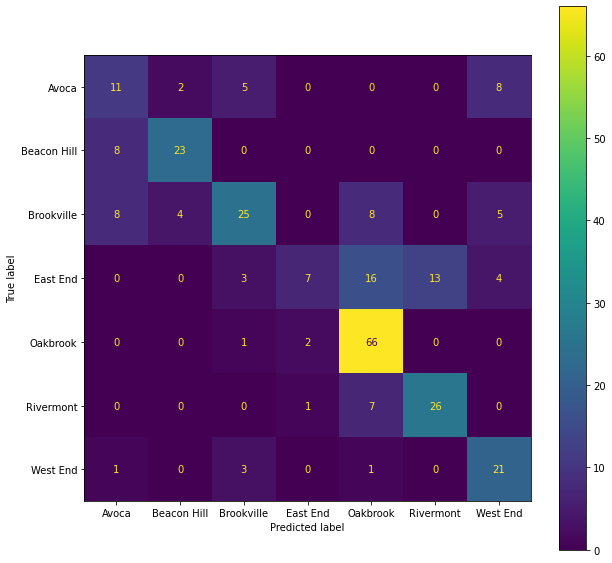

In [152]:
# note we get the labels (names) for the classes from the classifier
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [153]:
# note we get the labels (names) for the classes from the classifier
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.39      0.42      0.41        26
 Beacon Hill       0.79      0.74      0.77        31
  Brookville       0.68      0.50      0.57        50
    East End       0.70      0.16      0.26        43
    Oakbrook       0.67      0.96      0.79        69
   Rivermont       0.67      0.76      0.71        34
    West End       0.55      0.81      0.66        26

    accuracy                           0.64       279
   macro avg       0.64      0.62      0.60       279
weighted avg       0.65      0.64      0.61       279



All are quite precise predicitions except for Avoca with a f1-score of 0.41. East end has a dismall recall score which means the model is not very good at predicting East End.

### Classification using Price, Size and Year Built

In [154]:
data = ts[["Price", "Size", "Year Built"]]
data.head()

,Price,Size,Year Built
Date of Sale,,,
2016-01-03,638740,1849,2011
2016-01-03,494549,1471,2009
2016-01-07,546330,1551,2009
2016-01-10,376039,1073,1963
2016-01-10,365696,1071,1959


In [155]:
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
knn = KNeighborsClassifier(n_neighbors=1)
m = knn.fit(data_scaled, target)
location1 = [272039, 2125, 2000]
unseen_data = np.array([location1])
# apply the same min-max- normalisation as before
unseen_scaled = normalizer.transform(unseen_data)
prediction = knn.predict(unseen_scaled)
prediction[0]

'West End'

In [156]:
# use 70% for training, 30% for testing
data_train, data_test, target_train, target_test = train_test_split(data_scaled, target, 
    test_size=0.3, random_state=1)
print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])

Training set has 649 examples
Test set has 279 examples


In [157]:
model = KNeighborsClassifier(n_neighbors=1)
m = model.fit(data_train, target_train)

In [158]:
predicted = model.predict(data_test)
# print the predictions
print("Predictions:\n%s" % predicted)
# print the number of predictions from each class
print("\nClass counts:\n%s" % pd.Series(predicted).value_counts())

Predictions:
['West End' 'Brookville' 'West End' 'East End' 'East End' 'Avoca'
 'Rivermont' 'Oakbrook' 'West End' 'Brookville' 'Brookville' 'Oakbrook'
 'Beacon Hill' 'East End' 'Brookville' 'East End' 'Brookville'
 'Brookville' 'West End' 'East End' 'Rivermont' 'Oakbrook' 'Brookville'
 'West End' 'West End' 'Avoca' 'Brookville' 'Oakbrook' 'Oakbrook'
 'Oakbrook' 'Rivermont' 'Brookville' 'Brookville' 'Oakbrook' 'Brookville'
 'Oakbrook' 'Beacon Hill' 'Brookville' 'West End' 'West End' 'Beacon Hill'
 'East End' 'Oakbrook' 'Rivermont' 'East End' 'Beacon Hill' 'Oakbrook'
 'East End' 'East End' 'Oakbrook' 'Rivermont' 'Avoca' 'West End'
 'Oakbrook' 'Oakbrook' 'Oakbrook' 'Rivermont' 'Oakbrook' 'Rivermont'
 'Brookville' 'Brookville' 'Rivermont' 'Brookville' 'Oakbrook' 'East End'
 'Oakbrook' 'Brookville' 'Oakbrook' 'Brookville' 'West End' 'Oakbrook'
 'Beacon Hill' 'Oakbrook' 'Oakbrook' 'West End' 'East End' 'Brookville'
 'Beacon Hill' 'Brookville' 'Rivermont' 'Rivermont' 'East End' 'Oakbrook'
 'O

In [159]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.638


Another strong accuracy score but still less than using all numeric attributes. Still it is a strong model for classifing the location

In [160]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.638
K=02 neighbours: Accuracy=0.634
K=03 neighbours: Accuracy=0.652
K=04 neighbours: Accuracy=0.677
K=05 neighbours: Accuracy=0.681
K=06 neighbours: Accuracy=0.674
K=07 neighbours: Accuracy=0.652
K=08 neighbours: Accuracy=0.652
K=09 neighbours: Accuracy=0.645
K=10 neighbours: Accuracy=0.659
K=11 neighbours: Accuracy=0.656
K=12 neighbours: Accuracy=0.659
K=13 neighbours: Accuracy=0.638
K=14 neighbours: Accuracy=0.656
K=15 neighbours: Accuracy=0.652


At k = 5 we have the most accurate prediciton seen so war with an accuracy score od 0.681

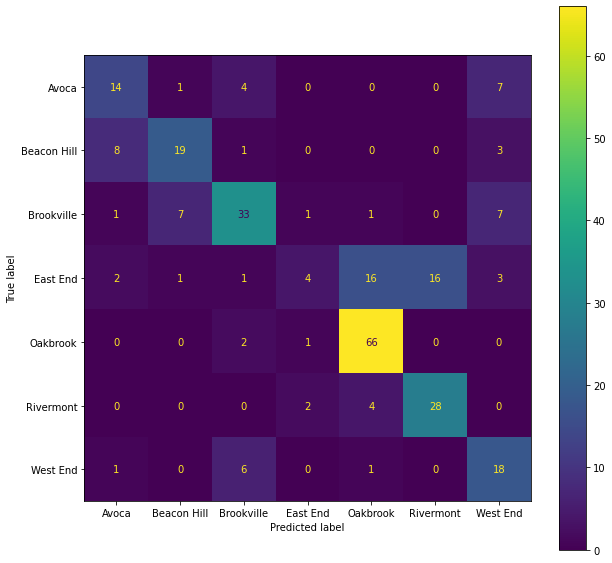

In [161]:
# note we get the labels (names) for the classes from the classifier
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [162]:
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.54      0.54      0.54        26
 Beacon Hill       0.68      0.61      0.64        31
  Brookville       0.70      0.66      0.68        50
    East End       0.50      0.09      0.16        43
    Oakbrook       0.75      0.96      0.84        69
   Rivermont       0.64      0.82      0.72        34
    West End       0.47      0.69      0.56        26

    accuracy                           0.65       279
   macro avg       0.61      0.63      0.59       279
weighted avg       0.64      0.65      0.62       279



East End again has a terribly poor recall score. All appear to be slightly less precise compared to when I used all features to make a classification.

### Classification of Size and Price

In [163]:
data = ts[["Price", "Size"]]
data.head()

,Price,Size
Date of Sale,,
2016-01-03,638740,1849
2016-01-03,494549,1471
2016-01-07,546330,1551
2016-01-10,376039,1073
2016-01-10,365696,1071


In [164]:
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
knn = KNeighborsClassifier(n_neighbors=1)
m = knn.fit(data_scaled, target)
location1 = [872039, 2015]
unseen_data = np.array([location1])
# apply the same min-max- normalisation as before
unseen_scaled = normalizer.transform(unseen_data)
prediction = knn.predict(unseen_scaled)
prediction[0]

'Brookville'

In [165]:
# use 70% for training, 30% for testing
data_train, data_test, target_train, target_test = train_test_split(data_scaled, target, 
    test_size=0.3, random_state=1)
print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])

Training set has 649 examples
Test set has 279 examples


In [166]:
model = KNeighborsClassifier(n_neighbors=1)
m = model.fit(data_train, target_train)

In [167]:
predicted = model.predict(data_test)
# print the predictions
print("Predictions:\n%s" % predicted)
# print the number of predictions from each class
print("\nClass counts:\n%s" % pd.Series(predicted).value_counts())

Predictions:
['West End' 'Brookville' 'West End' 'Oakbrook' 'East End' 'Oakbrook'
 'Brookville' 'Oakbrook' 'West End' 'Brookville' 'Brookville' 'Oakbrook'
 'Beacon Hill' 'East End' 'Brookville' 'East End' 'Oakbrook' 'West End'
 'West End' 'Brookville' 'Oakbrook' 'Rivermont' 'Brookville' 'West End'
 'Brookville' 'Avoca' 'Brookville' 'Rivermont' 'Oakbrook' 'East End'
 'Rivermont' 'Brookville' 'Brookville' 'East End' 'Oakbrook' 'Rivermont'
 'Beacon Hill' 'Oakbrook' 'West End' 'Brookville' 'Beacon Hill' 'East End'
 'Avoca' 'Rivermont' 'Rivermont' 'Beacon Hill' 'East End' 'East End'
 'Oakbrook' 'Oakbrook' 'East End' 'Avoca' 'West End' 'Oakbrook' 'Oakbrook'
 'West End' 'Oakbrook' 'Brookville' 'Rivermont' 'Oakbrook' 'Oakbrook'
 'East End' 'Brookville' 'Brookville' 'East End' 'Brookville' 'Avoca'
 'East End' 'West End' 'West End' 'Avoca' 'Beacon Hill' 'Rivermont'
 'Rivermont' 'Avoca' 'Brookville' 'Oakbrook' 'Beacon Hill' 'Brookville'
 'Rivermont' 'Rivermont' 'East End' 'Avoca' 'Oakbrook' 'Avoc

In [168]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.430


Price and size is not very accurate when classifing locations.

In [169]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.430
K=02 neighbours: Accuracy=0.401
K=03 neighbours: Accuracy=0.401
K=04 neighbours: Accuracy=0.441
K=05 neighbours: Accuracy=0.452
K=06 neighbours: Accuracy=0.459
K=07 neighbours: Accuracy=0.441
K=08 neighbours: Accuracy=0.473
K=09 neighbours: Accuracy=0.462
K=10 neighbours: Accuracy=0.495
K=11 neighbours: Accuracy=0.452
K=12 neighbours: Accuracy=0.477
K=13 neighbours: Accuracy=0.459
K=14 neighbours: Accuracy=0.455
K=15 neighbours: Accuracy=0.430


It is never above 0.5 for accuracy

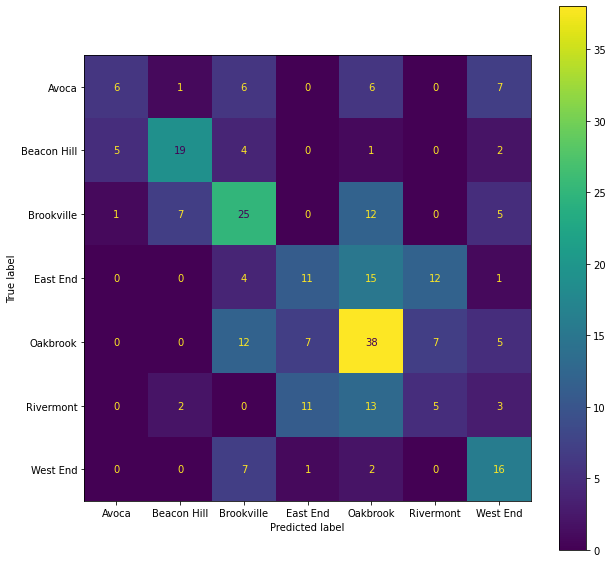

In [170]:
# note we get the labels (names) for the classes from the classifier
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [171]:
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.50      0.23      0.32        26
 Beacon Hill       0.66      0.61      0.63        31
  Brookville       0.43      0.50      0.46        50
    East End       0.37      0.26      0.30        43
    Oakbrook       0.44      0.55      0.49        69
   Rivermont       0.21      0.15      0.17        34
    West End       0.41      0.62      0.49        26

    accuracy                           0.43       279
   macro avg       0.43      0.42      0.41       279
weighted avg       0.42      0.43      0.42       279



Price and Size is not a good classifier compared to the previous two we have seen.

### Classification of Bathrooms and Bedrooms 

In [172]:
data = ts[["Price", "Size"]]
data.head()

,Price,Size
Date of Sale,,
2016-01-03,638740,1849
2016-01-03,494549,1471
2016-01-07,546330,1551
2016-01-10,376039,1073
2016-01-10,365696,1071


In [173]:
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
knn = KNeighborsClassifier(n_neighbors=1)
m = knn.fit(data_scaled, target)
location1 = [2, 2]
unseen_data = np.array([location1])
# apply the same min-max- normalisation as before
unseen_scaled = normalizer.transform(unseen_data)
prediction = knn.predict(unseen_scaled)
prediction[0]

'Rivermont'

In [174]:
# use 70% for training, 30% for testing
data_train, data_test, target_train, target_test = train_test_split(data_scaled, target, 
    test_size=0.3, random_state=1)
print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])

Training set has 649 examples
Test set has 279 examples


In [175]:
model = KNeighborsClassifier(n_neighbors=1)
m = model.fit(data_train, target_train)

In [176]:
predicted = model.predict(data_test)
# print the predictions
print("Predictions:\n%s" % predicted)
# print the number of predictions from each class
print("\nClass counts:\n%s" % pd.Series(predicted).value_counts())

Predictions:
['West End' 'Brookville' 'West End' 'Oakbrook' 'East End' 'Oakbrook'
 'Brookville' 'Oakbrook' 'West End' 'Brookville' 'Brookville' 'Oakbrook'
 'Beacon Hill' 'East End' 'Brookville' 'East End' 'Oakbrook' 'West End'
 'West End' 'Brookville' 'Oakbrook' 'Rivermont' 'Brookville' 'West End'
 'Brookville' 'Avoca' 'Brookville' 'Rivermont' 'Oakbrook' 'East End'
 'Rivermont' 'Brookville' 'Brookville' 'East End' 'Oakbrook' 'Rivermont'
 'Beacon Hill' 'Oakbrook' 'West End' 'Brookville' 'Beacon Hill' 'East End'
 'Avoca' 'Rivermont' 'Rivermont' 'Beacon Hill' 'East End' 'East End'
 'Oakbrook' 'Oakbrook' 'East End' 'Avoca' 'West End' 'Oakbrook' 'Oakbrook'
 'West End' 'Oakbrook' 'Brookville' 'Rivermont' 'Oakbrook' 'Oakbrook'
 'East End' 'Brookville' 'Brookville' 'East End' 'Brookville' 'Avoca'
 'East End' 'West End' 'West End' 'Avoca' 'Beacon Hill' 'Rivermont'
 'Rivermont' 'Avoca' 'Brookville' 'Oakbrook' 'Beacon Hill' 'Brookville'
 'Rivermont' 'Rivermont' 'East End' 'Avoca' 'Oakbrook' 'Avoc

In [177]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.430


Bathrooms and Bedrooms surprisingly has a similar accuracy score as the Price and Size. This is surprising due to the lack of variation in the data.

In [178]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.430
K=02 neighbours: Accuracy=0.401
K=03 neighbours: Accuracy=0.401
K=04 neighbours: Accuracy=0.441
K=05 neighbours: Accuracy=0.452
K=06 neighbours: Accuracy=0.459
K=07 neighbours: Accuracy=0.441
K=08 neighbours: Accuracy=0.473
K=09 neighbours: Accuracy=0.462
K=10 neighbours: Accuracy=0.495
K=11 neighbours: Accuracy=0.452
K=12 neighbours: Accuracy=0.477
K=13 neighbours: Accuracy=0.459
K=14 neighbours: Accuracy=0.455
K=15 neighbours: Accuracy=0.430


K = 12 is the most accurate at 0.477

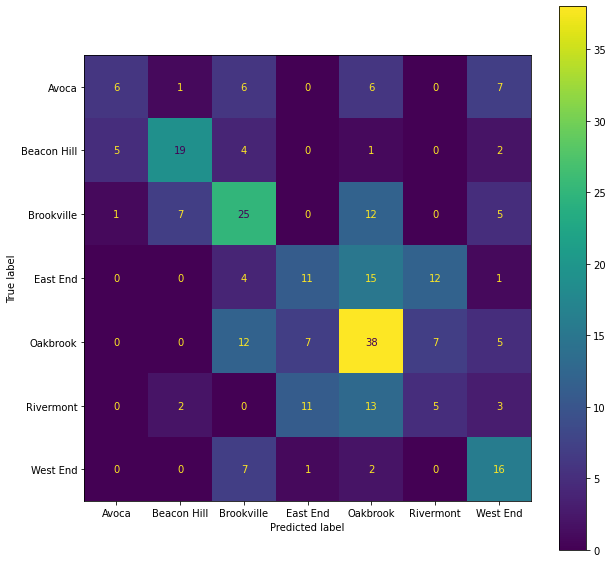

In [179]:
# note we get the labels (names) for the classes from the classifier
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [180]:
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.50      0.23      0.32        26
 Beacon Hill       0.66      0.61      0.63        31
  Brookville       0.43      0.50      0.46        50
    East End       0.37      0.26      0.30        43
    Oakbrook       0.44      0.55      0.49        69
   Rivermont       0.21      0.15      0.17        34
    West End       0.41      0.62      0.49        26

    accuracy                           0.43       279
   macro avg       0.43      0.42      0.41       279
weighted avg       0.42      0.43      0.42       279



Bathrooms and Bedrooms is better than I expected it to be at  classifing but still is not particularly good. With less than half of the predicitions being accurate.

### Classification of Size and Stories

In [181]:
data = ts[["Size", "Stories"]]
data.head()

,Size,Stories
Date of Sale,,
2016-01-03,1849,2.0
2016-01-03,1471,1.0
2016-01-07,1551,1.0
2016-01-10,1073,1.0
2016-01-10,1071,1.0


In [182]:
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
knn = KNeighborsClassifier(n_neighbors=1)
m = knn.fit(data_scaled, target)
location1 = [1234, 2]
unseen_data = np.array([location1])
# apply the same min-max- normalisation as before
unseen_scaled = normalizer.transform(unseen_data)
prediction = knn.predict(unseen_scaled)
prediction[0]

'Avoca'

In [183]:
# use 70% for training, 30% for testing
data_train, data_test, target_train, target_test = train_test_split(data_scaled, target, 
    test_size=0.3, random_state=1)
print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])

Training set has 649 examples
Test set has 279 examples


In [184]:
model = KNeighborsClassifier(n_neighbors=1)
m = model.fit(data_train, target_train)

In [185]:
predicted = model.predict(data_test)
# print the predictions
print("Predictions:\n%s" % predicted)
# print the number of predictions from each class
print("\nClass counts:\n%s" % pd.Series(predicted).value_counts())

Predictions:
['Rivermont' 'Avoca' 'West End' 'Rivermont' 'West End' 'Oakbrook'
 'Brookville' 'Rivermont' 'West End' 'East End' 'Oakbrook' 'East End'
 'Rivermont' 'Oakbrook' 'Brookville' 'Brookville' 'Avoca' 'Brookville'
 'Avoca' 'Rivermont' 'Brookville' 'Rivermont' 'West End' 'Avoca'
 'Brookville' 'Brookville' 'Avoca' 'West End' 'East End' 'Oakbrook'
 'Beacon Hill' 'Brookville' 'Brookville' 'Avoca' 'Oakbrook' 'Brookville'
 'Oakbrook' 'Rivermont' 'Brookville' 'West End' 'East End' 'Rivermont'
 'Oakbrook' 'Oakbrook' 'Rivermont' 'West End' 'Oakbrook' 'West End'
 'West End' 'Rivermont' 'Oakbrook' 'Avoca' 'West End' 'Oakbrook'
 'West End' 'Oakbrook' 'Oakbrook' 'East End' 'Brookville' 'Avoca'
 'Brookville' 'Avoca' 'Oakbrook' 'Oakbrook' 'Brookville' 'East End'
 'East End' 'West End' 'East End' 'West End' 'Oakbrook' 'Beacon Hill'
 'East End' 'Oakbrook' 'Avoca' 'Oakbrook' 'Rivermont' 'Rivermont'
 'Oakbrook' 'Avoca' 'West End' 'Rivermont' 'East End' 'Rivermont'
 'Oakbrook' 'Rivermont' 'Rivermont

In [186]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.287


Size and Stories are very bad at classifing with an accuracy score of 0.287. As we have seen alone they are not good at prediciting and this isn't helped when used together. It is clear that size isn't a unique idenetifer for each area. 

In [187]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.287
K=02 neighbours: Accuracy=0.251
K=03 neighbours: Accuracy=0.312
K=04 neighbours: Accuracy=0.301
K=05 neighbours: Accuracy=0.326
K=06 neighbours: Accuracy=0.280
K=07 neighbours: Accuracy=0.290
K=08 neighbours: Accuracy=0.280
K=09 neighbours: Accuracy=0.294
K=10 neighbours: Accuracy=0.308
K=11 neighbours: Accuracy=0.276
K=12 neighbours: Accuracy=0.280
K=13 neighbours: Accuracy=0.290
K=14 neighbours: Accuracy=0.305
K=15 neighbours: Accuracy=0.308


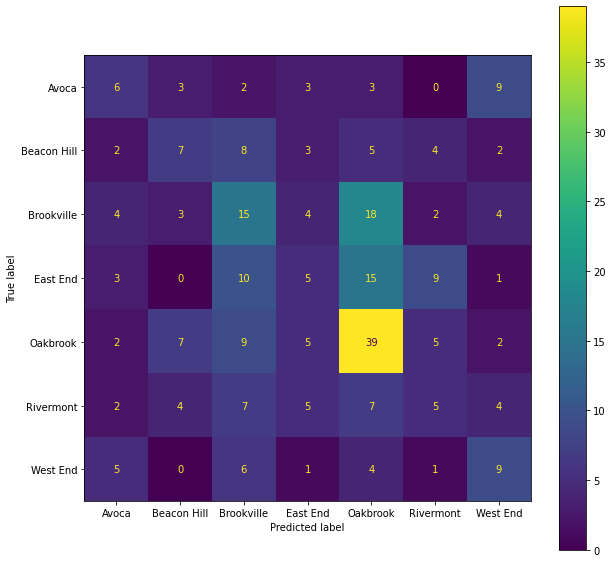

In [188]:
# note we get the labels (names) for the classes from the classifier
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [189]:
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.25      0.23      0.24        26
 Beacon Hill       0.29      0.23      0.25        31
  Brookville       0.26      0.30      0.28        50
    East End       0.19      0.12      0.14        43
    Oakbrook       0.43      0.57      0.49        69
   Rivermont       0.19      0.15      0.17        34
    West End       0.29      0.35      0.32        26

    accuracy                           0.31       279
   macro avg       0.27      0.28      0.27       279
weighted avg       0.29      0.31      0.29       279



A very poor classifier but still Oakbrook being the highest and almost a 0.5 f1-score. 

### Classification of Bedrooms, Bathrooms and Stories

In [190]:
data = ts[["Bedrooms", "Bathrooms", "Stories"]]
data.head()

,Bedrooms,Bathrooms,Stories
Date of Sale,,,
2016-01-03,3.0,2.0,2.0
2016-01-03,3.0,2.0,1.0
2016-01-07,3.0,2.0,1.0
2016-01-10,3.0,1.0,1.0
2016-01-10,3.0,1.0,1.0


In [191]:
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
knn = KNeighborsClassifier(n_neighbors=1)
m = knn.fit(data_scaled, target)
location1 = [2, 2, 1]
unseen_data = np.array([location1])
# apply the same min-max- normalisation as before
unseen_scaled = normalizer.transform(unseen_data)
prediction = knn.predict(unseen_scaled)
prediction[0]

'Oakbrook'

In [192]:
# use 70% for training, 30% for testing
data_train, data_test, target_train, target_test = train_test_split(data_scaled, target, 
    test_size=0.3, random_state=1)
print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])

Training set has 649 examples
Test set has 279 examples


In [193]:
model = KNeighborsClassifier(n_neighbors=1)
m = model.fit(data_train, target_train)

In [194]:
predicted = model.predict(data_test)
# print the predictions
print("Predictions:\n%s" % predicted)
# print the number of predictions from each class
print("\nClass counts:\n%s" % pd.Series(predicted).value_counts())

Predictions:
['Oakbrook' 'Brookville' 'Brookville' 'Oakbrook' 'Beacon Hill'
 'Brookville' 'East End' 'East End' 'Brookville' 'Brookville' 'Brookville'
 'Oakbrook' 'Brookville' 'Oakbrook' 'Avoca' 'Oakbrook' 'Rivermont'
 'Brookville' 'Brookville' 'East End' 'Beacon Hill' 'Brookville'
 'Rivermont' 'Brookville' 'Oakbrook' 'Brookville' 'Oakbrook' 'Oakbrook'
 'Oakbrook' 'Brookville' 'Oakbrook' 'Brookville' 'Brookville' 'Oakbrook'
 'Oakbrook' 'Oakbrook' 'Brookville' 'East End' 'Brookville' 'Brookville'
 'Brookville' 'Rivermont' 'Oakbrook' 'Beacon Hill' 'East End' 'Brookville'
 'Oakbrook' 'Oakbrook' 'Beacon Hill' 'Oakbrook' 'East End' 'Brookville'
 'Brookville' 'Oakbrook' 'West End' 'Oakbrook' 'East End' 'Oakbrook'
 'East End' 'Brookville' 'Oakbrook' 'Rivermont' 'Brookville' 'Rivermont'
 'East End' 'Oakbrook' 'Brookville' 'Oakbrook' 'Brookville' 'Avoca'
 'Oakbrook' 'Oakbrook' 'East End' 'Oakbrook' 'Brookville' 'Brookville'
 'Oakbrook' 'Oakbrook' 'Brookville' 'Oakbrook' 'Oakbrook' 'Rivermont'
 

In [195]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.380


Stories drages down Bathrooms and Bedrooms which had a higher classification accuracy together. 

In [196]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.380
K=02 neighbours: Accuracy=0.355
K=03 neighbours: Accuracy=0.419
K=04 neighbours: Accuracy=0.380
K=05 neighbours: Accuracy=0.427
K=06 neighbours: Accuracy=0.434
K=07 neighbours: Accuracy=0.437
K=08 neighbours: Accuracy=0.441
K=09 neighbours: Accuracy=0.448
K=10 neighbours: Accuracy=0.441
K=11 neighbours: Accuracy=0.437
K=12 neighbours: Accuracy=0.444
K=13 neighbours: Accuracy=0.437
K=14 neighbours: Accuracy=0.437
K=15 neighbours: Accuracy=0.444


highest at k = 9

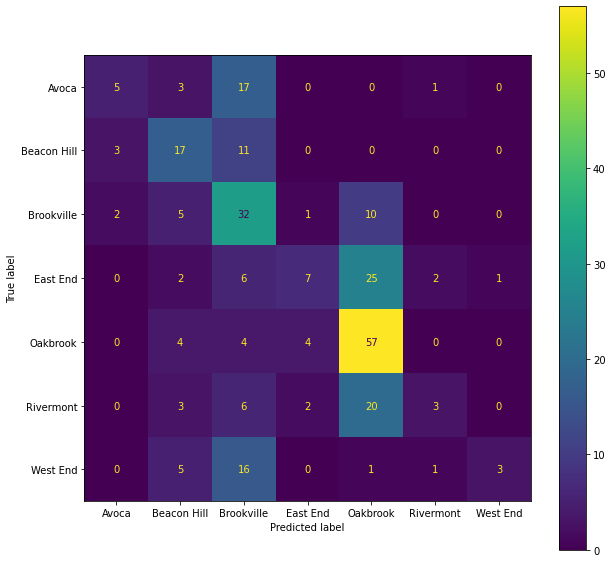

In [197]:
# note we get the labels (names) for the classes from the classifier
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [198]:
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.50      0.19      0.28        26
 Beacon Hill       0.44      0.55      0.49        31
  Brookville       0.35      0.64      0.45        50
    East End       0.50      0.16      0.25        43
    Oakbrook       0.50      0.83      0.63        69
   Rivermont       0.43      0.09      0.15        34
    West End       0.75      0.12      0.20        26

    accuracy                           0.44       279
   macro avg       0.50      0.37      0.35       279
weighted avg       0.48      0.44      0.39       279



### Classification of Price and Year Built

In [199]:
data = ts[["Price", "Year Built"]]
data.head()

,Price,Year Built
Date of Sale,,
2016-01-03,638740,2011
2016-01-03,494549,2009
2016-01-07,546330,2009
2016-01-10,376039,1963
2016-01-10,365696,1959


In [200]:
normalizer = MinMaxScaler()  
data_scaled = normalizer.fit_transform(data.values)
knn = KNeighborsClassifier(n_neighbors=1)
m = knn.fit(data_scaled, target)
location1 = [600000, 2002]
unseen_data = np.array([location1])
# apply the same min-max- normalisation as before
unseen_scaled = normalizer.transform(unseen_data)
prediction = knn.predict(unseen_scaled)
prediction[0]

'West End'

In [201]:
# use 70% for training, 30% for testing
data_train, data_test, target_train, target_test = train_test_split(data_scaled, target, 
    test_size=0.3, random_state=1)
print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])

Training set has 649 examples
Test set has 279 examples


In [202]:
model = KNeighborsClassifier(n_neighbors=1)
m = model.fit(data_train, target_train)

In [203]:
predicted = model.predict(data_test)
# print the predictions
print("Predictions:\n%s" % predicted)
# print the number of predictions from each class
print("\nClass counts:\n%s" % pd.Series(predicted).value_counts())

Predictions:
['West End' 'Brookville' 'Brookville' 'Brookville' 'Rivermont' 'Avoca'
 'Oakbrook' 'Oakbrook' 'West End' 'Brookville' 'Brookville' 'Oakbrook'
 'Beacon Hill' 'East End' 'West End' 'East End' 'Avoca' 'Brookville'
 'Beacon Hill' 'Brookville' 'Oakbrook' 'Rivermont' 'Avoca' 'West End'
 'West End' 'East End' 'Brookville' 'Oakbrook' 'Oakbrook' 'Oakbrook'
 'Rivermont' 'Brookville' 'Brookville' 'East End' 'Oakbrook' 'Oakbrook'
 'Brookville' 'Brookville' 'West End' 'West End' 'Brookville' 'Rivermont'
 'Oakbrook' 'East End' 'Rivermont' 'Avoca' 'Oakbrook' 'Rivermont'
 'East End' 'Oakbrook' 'Rivermont' 'Avoca' 'Brookville' 'Oakbrook'
 'Brookville' 'Oakbrook' 'Rivermont' 'Oakbrook' 'Rivermont' 'Brookville'
 'Brookville' 'Rivermont' 'Brookville' 'Oakbrook' 'East End' 'Oakbrook'
 'Brookville' 'Oakbrook' 'West End' 'Avoca' 'Oakbrook' 'Beacon Hill'
 'Oakbrook' 'Oakbrook' 'West End' 'Brookville' 'Brookville' 'Beacon Hill'
 'Beacon Hill' 'Rivermont' 'Rivermont' 'East End' 'Oakbrook' 'Oakbrook

In [204]:
acc = accuracy_score(target_test, predicted)
print("Accuracy=%.3f" % acc)

Accuracy=0.606


Price and Year Built is a good classifier with an accuracy score of 0.649.

In [205]:
for k in range(1, 16):
    # train a classifier with this parameter value
    model = KNeighborsClassifier(n_neighbors=k)
    m = model.fit(data_train, target_train)
    # make predictions
    predicted = model.predict(data_test)
    # evaluate the predictions
    acc = accuracy_score(target_test, predicted)
    print("K=%02d neighbours: Accuracy=%.3f" % (k, acc))

K=01 neighbours: Accuracy=0.606
K=02 neighbours: Accuracy=0.581
K=03 neighbours: Accuracy=0.588
K=04 neighbours: Accuracy=0.609
K=05 neighbours: Accuracy=0.591
K=06 neighbours: Accuracy=0.620
K=07 neighbours: Accuracy=0.606
K=08 neighbours: Accuracy=0.627
K=09 neighbours: Accuracy=0.620
K=10 neighbours: Accuracy=0.649
K=11 neighbours: Accuracy=0.656
K=12 neighbours: Accuracy=0.649
K=13 neighbours: Accuracy=0.645
K=14 neighbours: Accuracy=0.649
K=15 neighbours: Accuracy=0.649


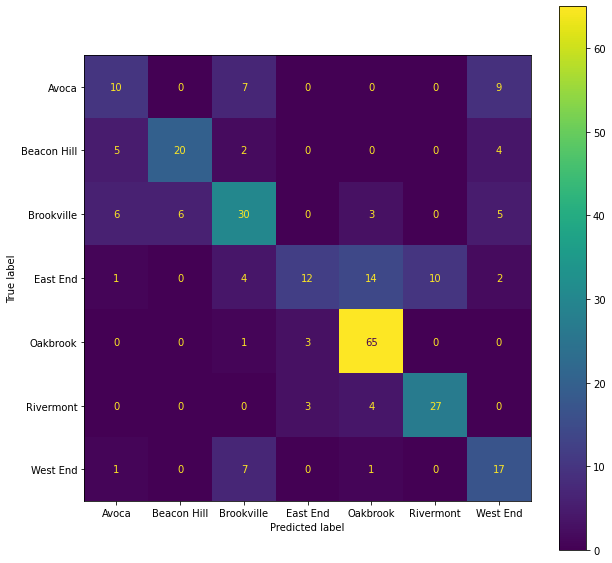

In [206]:
# note we get the labels (names) for the classes from the classifier
cm = confusion_matrix(target_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

In [207]:
print(classification_report(target_test, predicted, target_names=knn.classes_))

              precision    recall  f1-score   support

       Avoca       0.43      0.38      0.41        26
 Beacon Hill       0.77      0.65      0.70        31
  Brookville       0.59      0.60      0.59        50
    East End       0.67      0.28      0.39        43
    Oakbrook       0.75      0.94      0.83        69
   Rivermont       0.73      0.79      0.76        34
    West End       0.46      0.65      0.54        26

    accuracy                           0.65       279
   macro avg       0.63      0.61      0.60       279
weighted avg       0.65      0.65      0.63       279



Year Built and Price is one of the better classifiers I have used so far with an accuracy score of 0.63 which is a good, not great, classifer.

The best attributes for classification appear to be a combination including Year Built. With all combinations I used that included year built being above 0.6 accuracy score. This could be due to the fact that houses in each area are built at similar times. When building homes those in the same area are often built during the same time period. This would allow Year Built to be a good attribute to make accurate classifications. Size and Stories appear to be the worst classifiers. Size is not unique to a location as two houses in two different areas are quite likely to be of similar size. Stories like bathrooms and bedrooms have limited variance of values. All having 3 different values which makes it difficult for classifing the location as all locations are likely to have similar numbers for each of these features due to the lack of variation. Price is also quite poor for making classifications. As we have seen in previous exercises the bulk of houses in the different areas are similar. Thus leading to poor classification.